## Importing Libraries and load Data

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

In [323]:
# os.listdir()
data = pd.read_excel('TrainDataset2023.xls')
cols = data.columns.values

# Checking for improper column names
bad_names = [name for name in cols if re.findall(r"\W",name)]
repaired_names = [re.sub(r'\s|\(.+\)','',name) for name in cols]


# Rename columns
data.columns = repaired_names
data.columns


Index(['ID', 'pCR', 'RelapseFreeSurvival', 'Age', 'ER', 'PgR', 'HER2',
       'TrippleNegative', 'ChemoGrade', 'Proliferation',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=120)

# Data processing

In [324]:
# check duplicated rows
# No duplicates were found in data
duplicates = data.duplicated()
# duplicates[duplicates==True]
duplicates.any()

False

In [325]:
# Checking for missing values
# Missing values are coded as 999

for col in data.columns:
    data[col].replace(999,np.nan, inplace=True)

In [326]:
def check_missing(df):
    missing = df.isna().sum()
    missing = missing[missing>0]
    missing.sort_values(ascending=False,inplace=True)
    # print(missing)
    return(missing)

check_missing(data)

pCR                5
ChemoGrade         3
HistologyType      3
Proliferation      2
PgR                1
HER2               1
TrippleNegative    1
LNStatus           1
dtype: int64

In [327]:
# Since the target is outcome of treatment, imputing this variable may not be safe, therefore dropped from the dataset
# missing values in features can be imputed
data = data.loc[~data['pCR'].isna(),:]

# again check for missing values
check_missing(data)

ChemoGrade         3
HistologyType      3
Proliferation      2
PgR                1
HER2               1
TrippleNegative    1
LNStatus           1
dtype: int64

# checking unique values for each column
- This basically identifies categorical features in data, since no text labels were provided
- experiment with different thresholds to confirm

In [328]:
count_uni = dict()
for i,col in enumerate(data.columns.values):
    count_uni[col] = len(np.unique(data.loc[:,col]))

# print(count_uni)

list_cat = []
for key,val in count_uni.items():
    if count_uni[key]<10:
        list_cat.append(key)
        # print(f"{key}:{val}")

print(f"There are : {len(list_cat)} categotical fetures: {list_cat}")
    

There are : 10 categotical fetures: ['pCR', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage']


In [329]:
# drop ID column
# data.drop('ID',axis=1,inplace=True)
# data.columns

## Train test split
- Dataset is unbalanced, around 78 percent are negative samples for `pCR`. Therefore it is necessary that train-test split produce represenative sets 
- Train test split is done before even exploring the dataset! to ensure that the test set is unseen to avoid so called data snooping bias. Notewortthy, seeing full dataset before training may influence choice of particular algorithm, thus prone to overfitting to data. 


In [330]:
## Split the dataset into training and test sets, before pre-processing to avoid data leakage
from sklearn.model_selection import train_test_split


# For classification task
data_train, data_test = train_test_split(data,test_size=.20,shuffle=True,stratify=data['pCR'],random_state=0)

print(data_train.index)
# Lets rename our training data as df to avoid any confusion in subsequent stages
# From now nowards the training set will be df, and we have reserved `data_test` for evaluation
# df will be used for exploratory analysis only
df = data_train.copy()
df.drop('ID',axis=1,inplace=True)


Index([ 52, 341, 133,  17, 327,  76, 191, 112,  97, 267,
       ...
       209, 306, 280,  31, 383, 107,   2, 189, 297,   7],
      dtype='int64', length=316)


## EXPORT TEST DATA IN PRESCRIBED FORMAT

In [331]:
test_set_export = data_test.loc[:,~data_test.columns.isin(['pCR','RelapseFreeSurvival'])]
test_set_export.to_excel('test_set_PCR.xlsx',index=False)
test_set_export

ID        Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  \
246  TRG002709  53.683778   0  0.0   0.0              1.0         2.0   
349  TRG002870  66.300000   0  0.0   1.0              0.0         2.0   
47   TRG002384  62.000000   1  1.0   0.0              0.0         2.0   
219  TRG002671  48.243669   1  1.0   0.0              0.0         2.0   
215  TRG002664  46.102669   0  0.0   0.0              1.0         2.0   
..         ...        ...  ..  ...   ...              ...         ...   
184  TRG002616  51.723477   0  0.0   0.0              1.0         3.0   
375  TRG002917  33.500000   0  0.0   0.0              1.0         3.0   
359  TRG002881  56.400000   1  0.0   1.0              0.0         2.0   
361  TRG002883  48.100000   0  0.0   0.0              1.0         3.0   
186  TRG002618  59.425051   0  0.0   0.0              1.0         2.0   

     Proliferation  HistologyType  LNStatus  ...  \
246            1.0            1.0       0.0  ...   
349            1.0            1.0       0.0  ...   
47             1.0            2.0       0.0  ...   
219            1.0            1.0       1.0  ...   
215            1.0            1.0       0.0  ...   
..             ...            ...       ...  ...   
184            3.0            1.0       1.0  ...   
375            3.0            1.0       1.0  ...   
359            1.0            1.0       0.0  ...   
361            3.0            1.0       0.0  ...   
186            1.0            1.0       0.0  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  \
246                                       0.394504   
349                                       0.083383   
47                                        0.581353   
219                                       0.494625   
215                                       0.247294   
..                                             ...   
184                                       0.427951   
375                                       0.419745   
359                                       0.750567   
361                                       0.459564   
186                                       0.312501   

     original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
246                                      0.394503                    3.374972   
349                                      0.083377                    1.584963   
47                                       0.581353                    2.662413   
219                                      0.494625                    2.989961   
215                                      0.247294                    3.231270   
..                                            ...                         ...   
184                                      0.427951                    2.405639   
375                                      0.419745                    3.209020   
359                                      0.750567                    1.278358   
361                                      0.459564                    2.992289   
186                                      0.312501                    2.000000   

     original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
246                       0.005753                 1.887473e+06   
349                       0.005566                 3.750289e+04   
47                        0.003759                 8.709857e+06   
219                       0.005453                 2.047252e+06   
215                       0.006067                 4.546581e+05   
..                             ...                          ...   
184                       0.000725                 9.987773e+06   
375                       0.000763                 7.148966e+07   
359                       0.006743                 6.534741e+05   
361                       0.001523                 7.429380e+06   
186                       0.001442                 9.052902e+05   

     original_ngtdm_Busyness  original_ngtdm_Coarseness  \
246                64.25

In [264]:
# check distribution (proportions of positive vs negative samples) of data by pCR
p_df = df['pCR'].value_counts()/sum(df['pCR'].value_counts())
p_test = data_test['pCR'].value_counts()/sum(data_test['pCR'].value_counts())

print(p_df)
print(df.shape)
print(p_test)
print(data_test.shape)

pCR
0.0    0.787975
1.0    0.212025
Name: count, dtype: float64
(316, 119)
pCR
0.0    0.78481
1.0    0.21519
Name: count, dtype: float64
(79, 120)


## Imputing missing values
- KNN imputer is preferred since it imputes values based on closely similar datapoints
- One neigbor is used for imputation, this avoids meaningless imputation for categorical features
- To avoid data leakage, a test set is reserved before any data preprocessing
- This will be used to evaluate the models after training is completed
- imputation done here is just for exploratoty analysis

In [265]:
# replace missing values by imputation, 

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

try:
    tmp = imputer.fit_transform(df)
except KeyError:
    print('Variable not found')

imputer.feature_names_in_
imputer.n_features_in_

df_imp = pd.DataFrame(tmp,columns=imputer.get_feature_names_out())
# X_train.head()

print(df_imp.shape)
print(df.shape)

# check missing
check_missing(df_imp)

# df_imp = df.copy()

(316, 119)
(316, 119)


Series([], dtype: int64)

In [266]:
# Describe continuous features
df_imp.loc[:,~df_imp.columns.isin(list_cat+['RelapseFreeSurvival'])].describe()

Age  original_shape_Elongation  original_shape_Flatness  \
count  316.000000                 316.000000               316.000000   
mean    51.876780                   0.710749                 0.542419   
std     10.839987                   0.167934                 0.172217   
min     26.000000                   0.139299                 0.099076   
25%     44.914271                   0.608206                 0.410459   
50%     51.400410                   0.742441                 0.544493   
75%     60.000000                   0.837654                 0.684347   
max     78.992471                   0.975271                 0.867591   

       original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
count                      316.000000                      316.000000   
mean                        22.787123                       47.566120   
std                          9.603955                       30.345009   
min                          6.949963                       12.466885   
25%                         16.026812                       28.667227   
50%                         21.180313                       39.382335   
75%                         26.860076                       58.287983   
max                         92.516207                      326.866827   

       original_shape_Maximum2DDiameterColumn  \
count                              316.000000   
mean                                48.129795   
std                                 23.615385   
min                                 12.165525   
25%                                 31.956840   
50%                                 42.053537   
75%                                 59.407491   
max                                155.756220   

       original_shape_Maximum2DDiameterRow  \
count                           316.000000   
mean                             44.697605   
std                              26.783211   
min                              13.038405   
25%                              29.154759   
50%                              38.013099   
75%                              52.237402   
max                             241.530536   

       original_shape_Maximum2DDiameterSlice  \
count                             316.000000   
mean                               48.336160   
std                                28.716487   
min                                12.369317   
25%                                30.659406   
50%                                39.534696   
75%                                59.450223   
max                               237.033753   

       original_shape_Maximum3DDiameter  original_shape_MeshVolume  ...  \
count                        316.000000                 316.000000  ...   
mean                          56.571831               19585.804061  ...   
std                           32.041710               34522.511698  ...   
min                           15.524175                 711.375000  ...   
25%                           35.513698                5870.468750  ...   
50%                           47.869266               11989.520835  ...   
75%                           69.023535               23177.375000  ...   
max                          242.614921              528765.458300  ...   

       original_glszm_SmallAreaHighGrayLevelEmphasis  \
count                                   3.160000e+02   
mean                                    4.018802e-01   
std                                     1.696983e-01   
min                                     7.050000e-11   
25%                                     3.226039e-01   
50%                                     4.199629e-01   
75%                                     5.071885e-01   
max                                     8.652006e-01   

       original_glszm_SmallAreaLowGrayLevelEmphasis  \
count                                  3.160000e+02   
mean                                   3.983694e-01   
std                                    1.660302e-01   
min    

In [267]:
# Counts for target `pCR`and categorical features

for v in list_cat:
    print(df_imp[v].value_counts())

#data['pCR'].value_counts()

pCR
0.0    249
1.0     67
Name: count, dtype: int64
ER
1.0    178
0.0    138
Name: count, dtype: int64
PgR
0.0    185
1.0    131
Name: count, dtype: int64
HER2
0.0    217
1.0     99
Name: count, dtype: int64
TrippleNegative
0.0    211
1.0    105
Name: count, dtype: int64
ChemoGrade
2.0    190
3.0    124
1.0      2
Name: count, dtype: int64
Proliferation
1.0    190
2.0     75
3.0     51
Name: count, dtype: int64
HistologyType
1.0    265
2.0     51
Name: count, dtype: int64
LNStatus
1.0    163
0.0    153
Name: count, dtype: int64
TumourStage
2.0    142
3.0     82
4.0     67
1.0     25
Name: count, dtype: int64


In [268]:
# change categorical features to int for better hist plots
# data_cat = df_imp[list_cat]
# data_types =  data_cat.dtypes

# for feature in list_cat:
#     # if data_cat[feature].dtype!=object:
#     data_cat.loc[:,feature] = data_cat[feature].astype(int)


In [269]:
# change categorical features to int for better hist plots
data_cat = df_imp[list_cat]
data_types =  data_cat.dtypes

for feature in list_cat:
    # if data_cat[feature].dtype!=object:
    data_cat.loc[:,feature] = data_cat[feature].astype('int64')


## Categorical features versus `pCR`
- There are observed differences in counts between negative and positive samples for pGR, HistrologyType, TumorStage, etc..
- To be confirmed later by statistical tests, to ensure the observed differences are not by chance

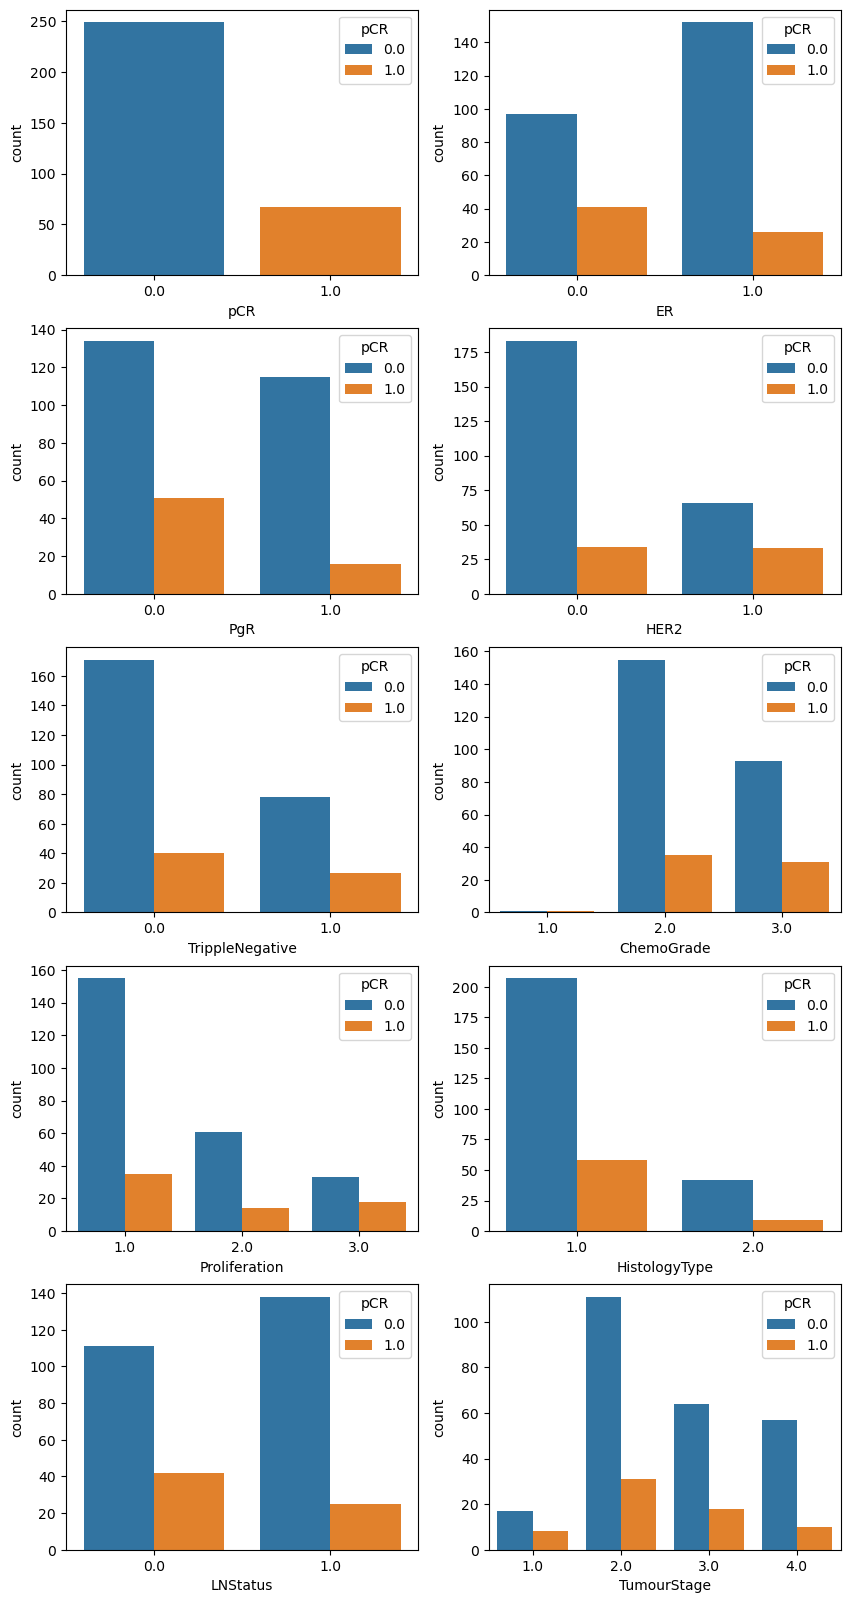

In [270]:

fig, axs = plt.subplots(5,2,figsize=(10,20))
for ax, series in zip(axs.ravel(),data_cat):
    sns.countplot(x=series,ax=ax, data=data_cat,hue='pCR')
# axs[0,0].set_title('ER')


## visualizing Continuous data
- so many features have outliers, these need be removed
- some are so huge, potentially indicating data entry errors

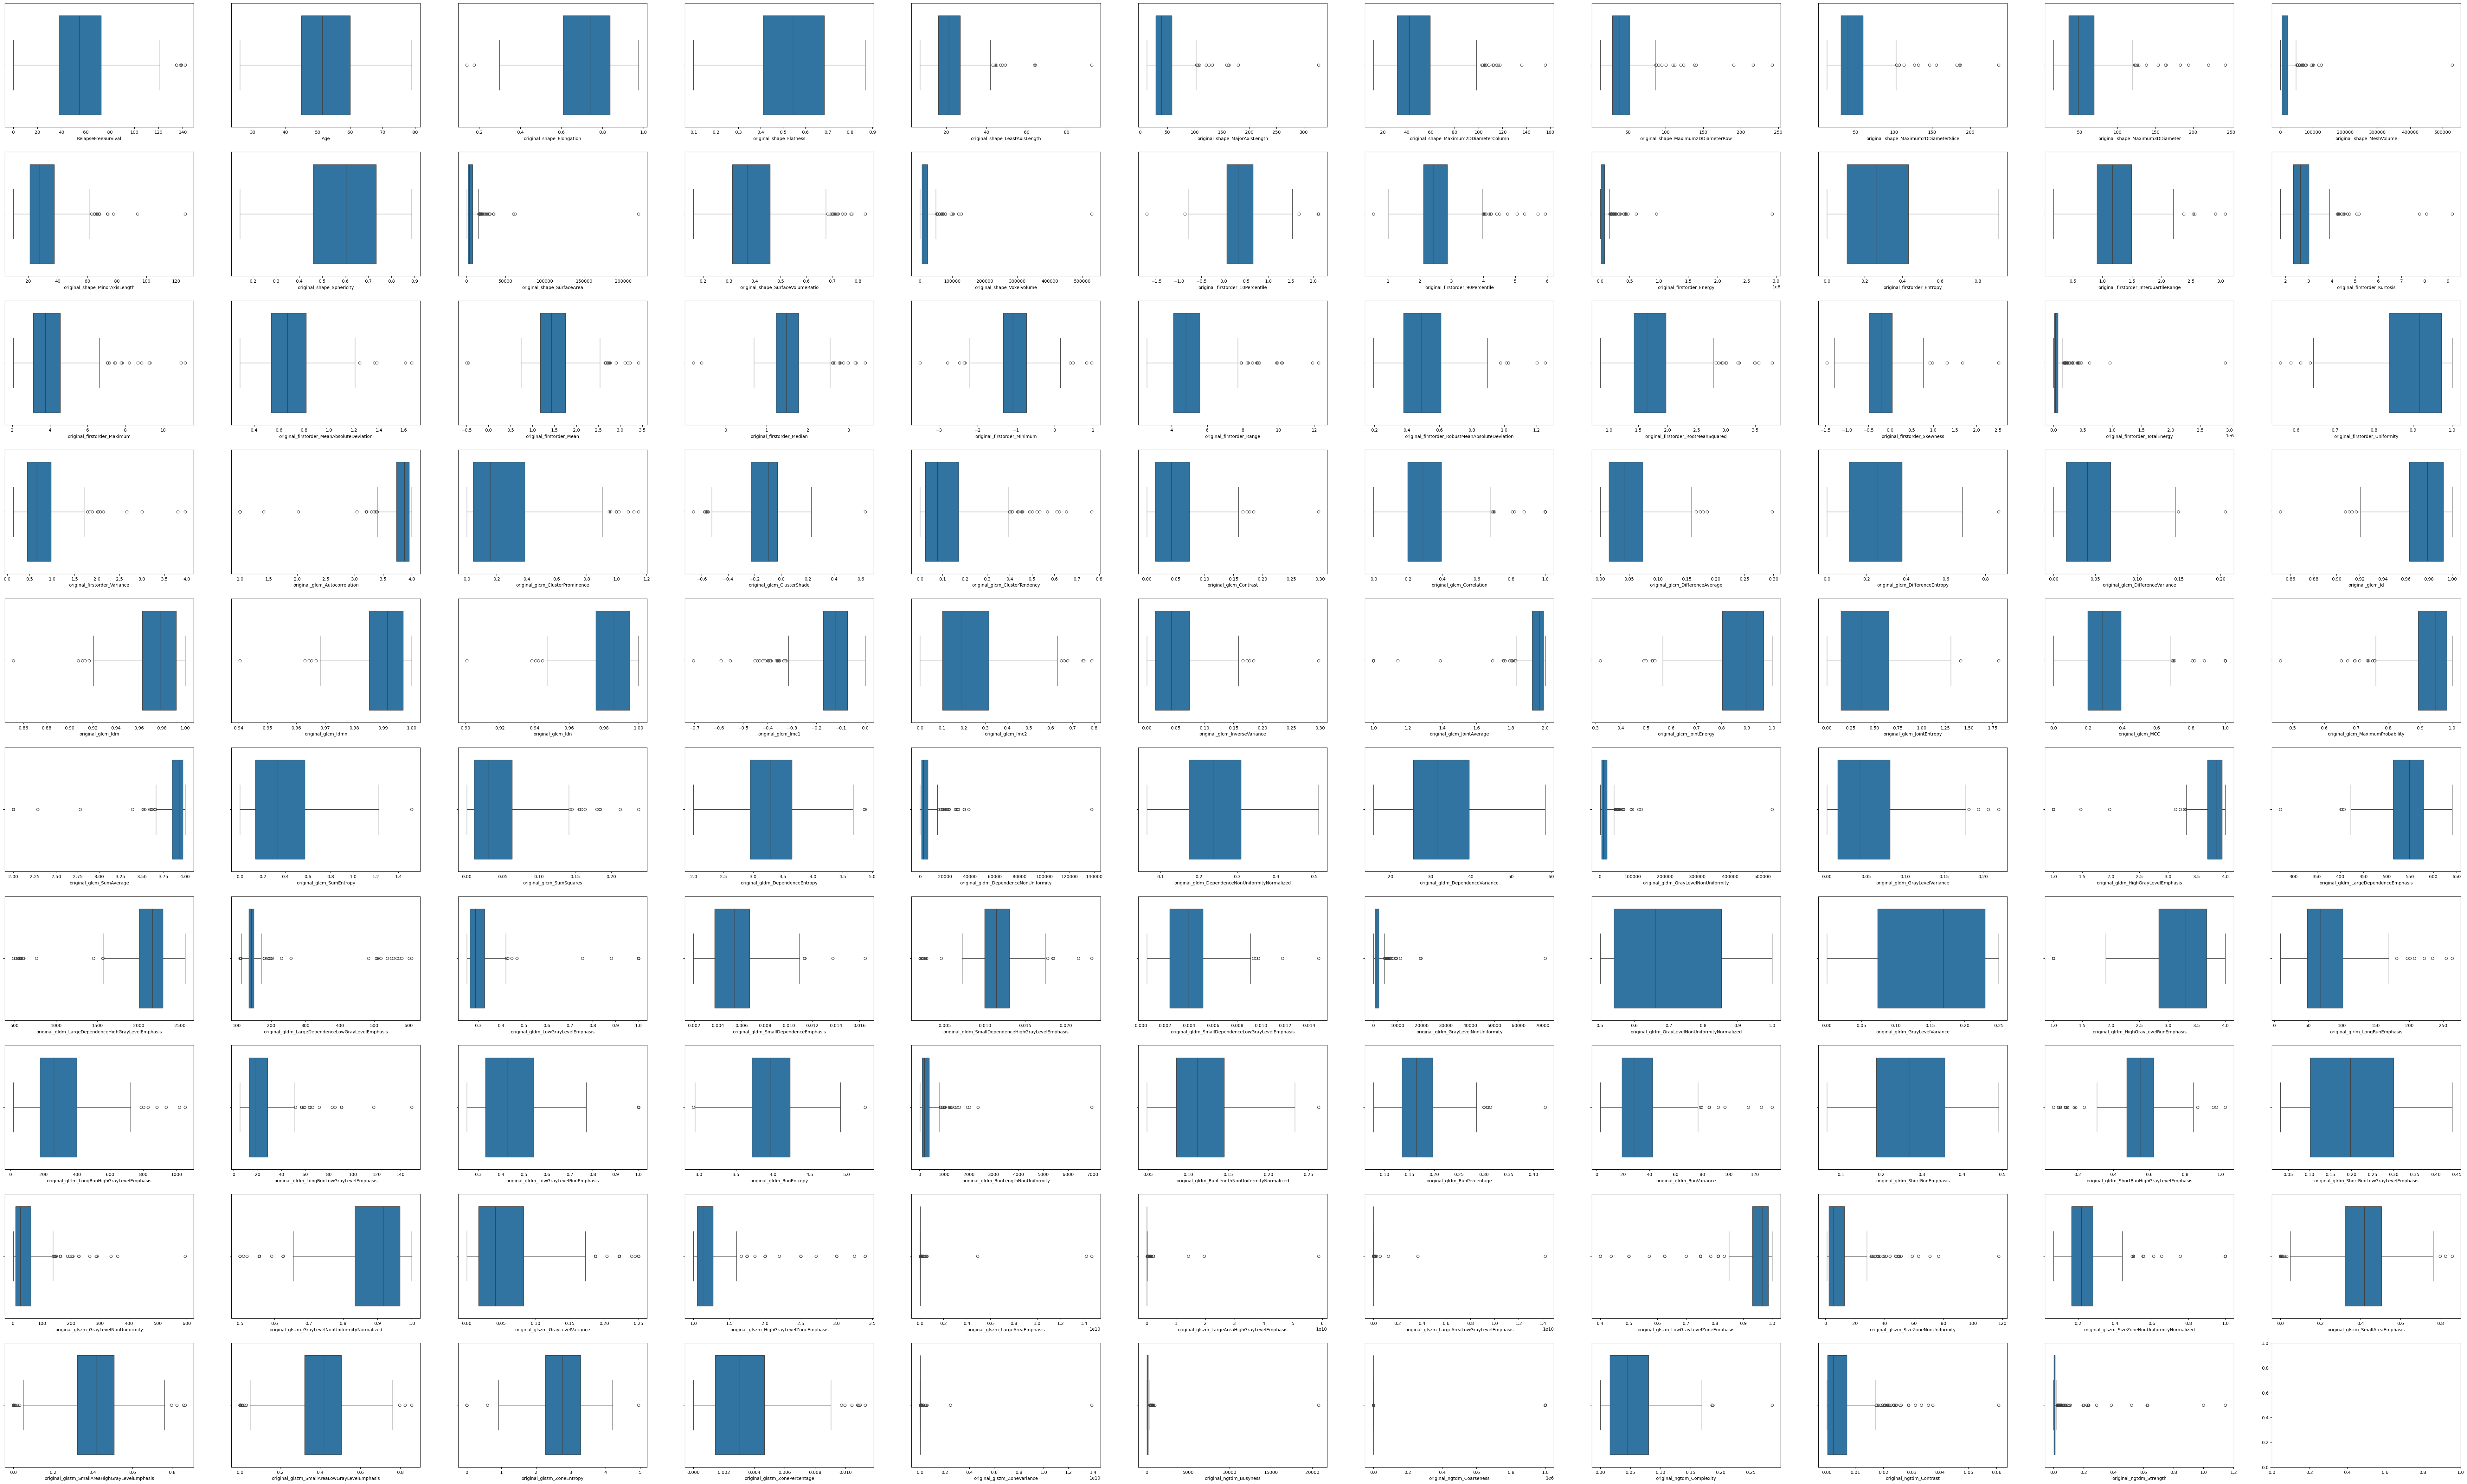

In [271]:
list_cont = [i for i in df_imp.columns.values if i not in list_cat]
data_cont = df_imp.loc[:,list_cont]


fig, axs = plt.subplots(10,11,figsize=(100,60))
for ax, series in zip(axs.ravel(),data_cont):
    sns.boxplot(x=series,ax=ax, data=data_cont)




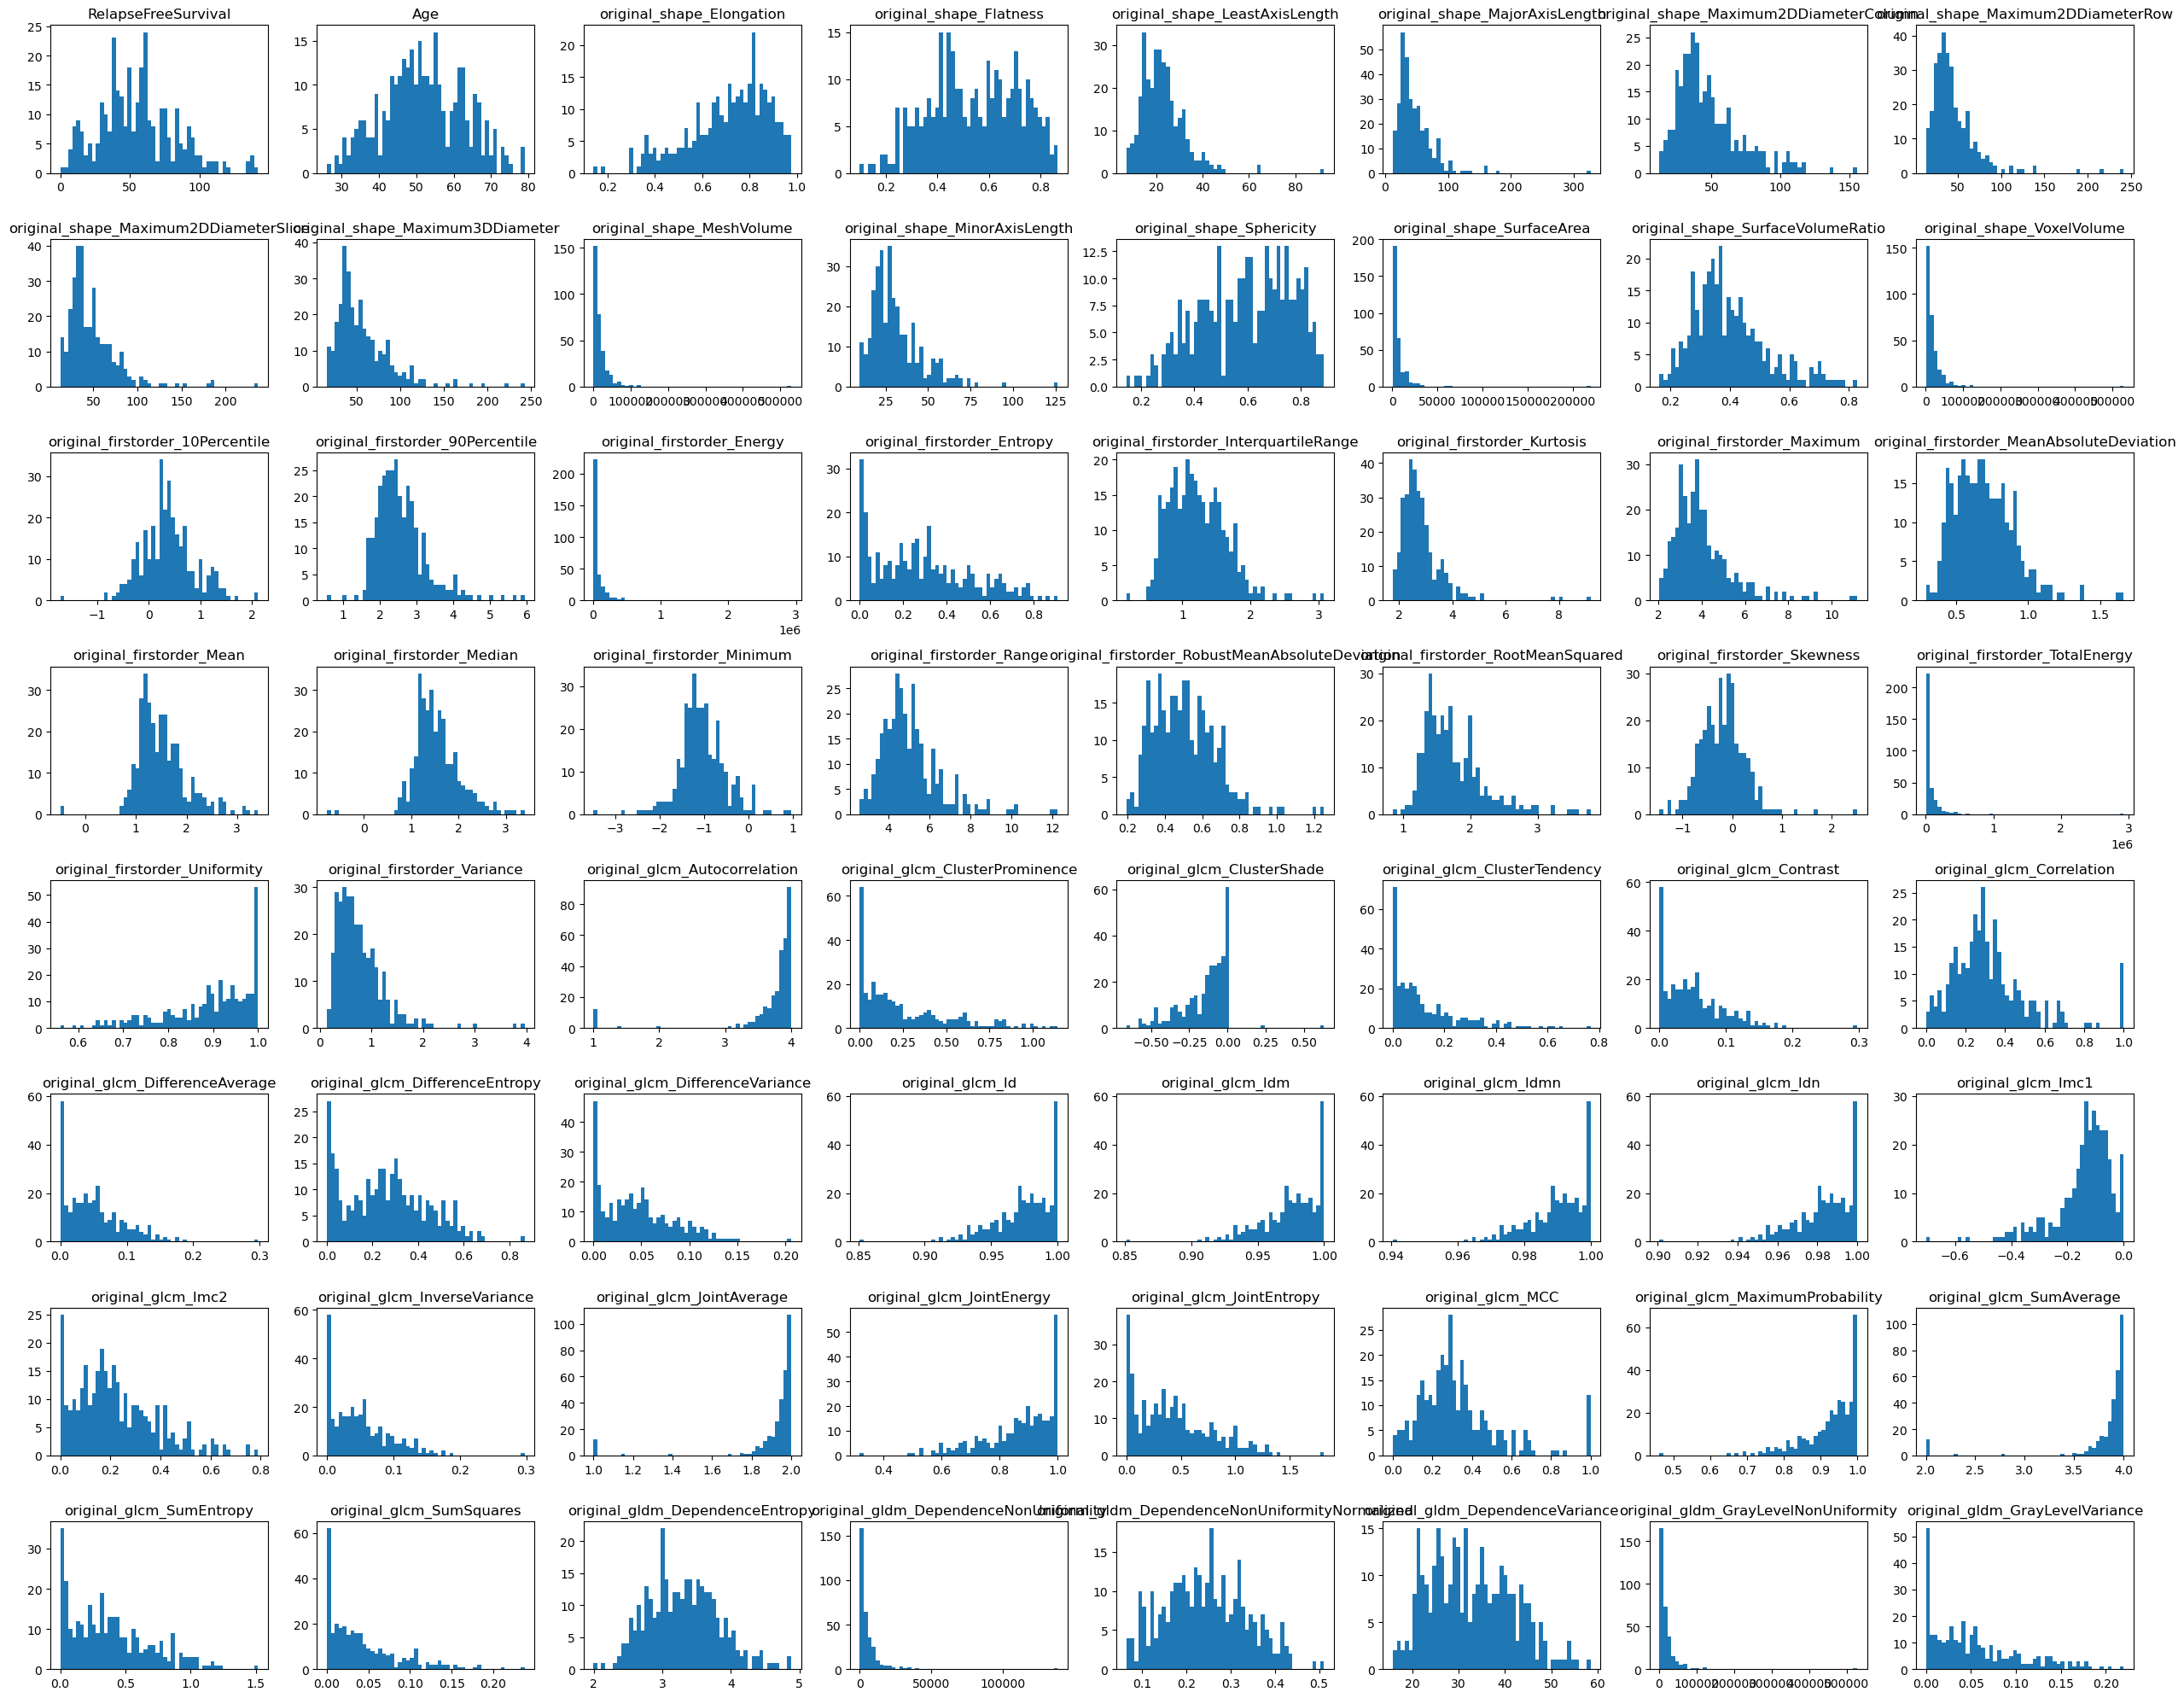

In [272]:

fig, axs = plt.subplots(8,8,figsize=(25,20))
axs = axs.ravel()
for i,col in enumerate(data_cont.iloc[:,0:64].columns.values):
    axs[i].hist(x=col,bins=50,data=data_cont.iloc[:,0:64])
    axs[i].set_title(col)
plt.tight_layout()

In [273]:
len(axs)

64

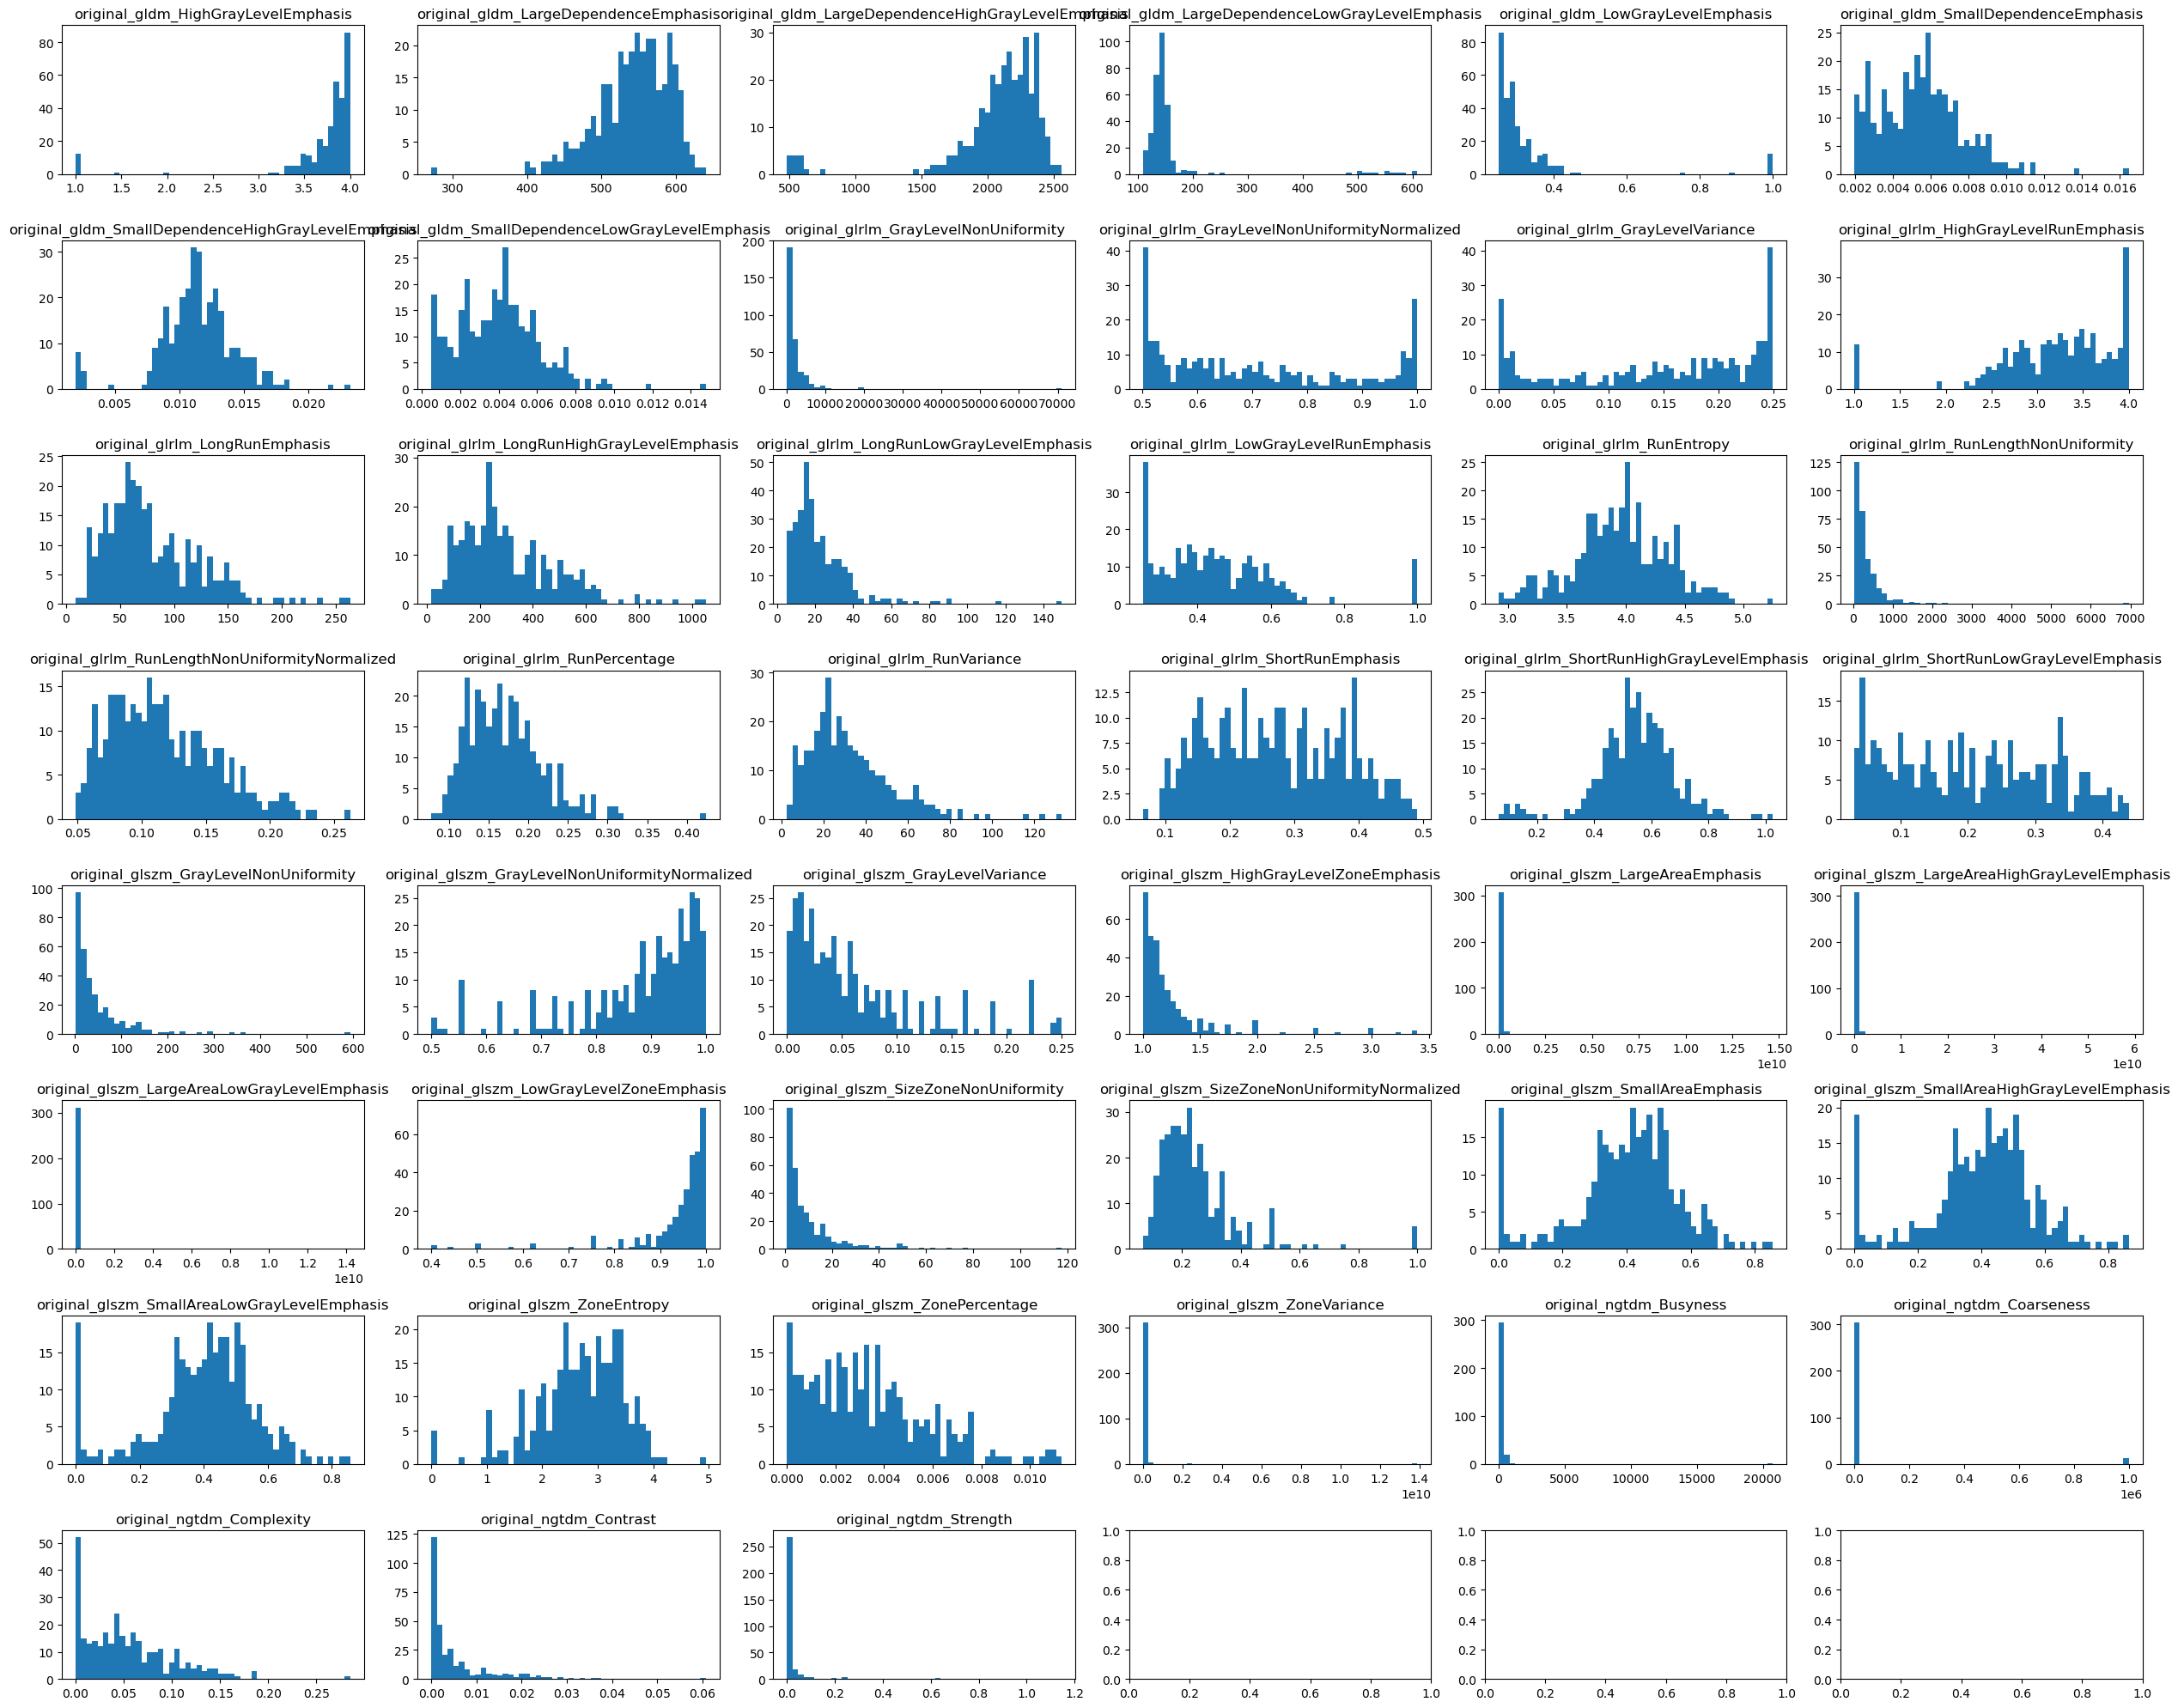

In [274]:
# data_cont.iloc[:,64:data_cont.shape[1]].hist(bins=50,figsize=(30,25))
fig, axs = plt.subplots(8,6,figsize=(25,20))
axs = axs.ravel()
for i,col in enumerate(data_cont.iloc[:,64:].columns.values):
    axs[i].hist(x=col,bins=50,data=data_cont.iloc[:,64:])
    axs[i].set_title(col)
plt.tight_layout()

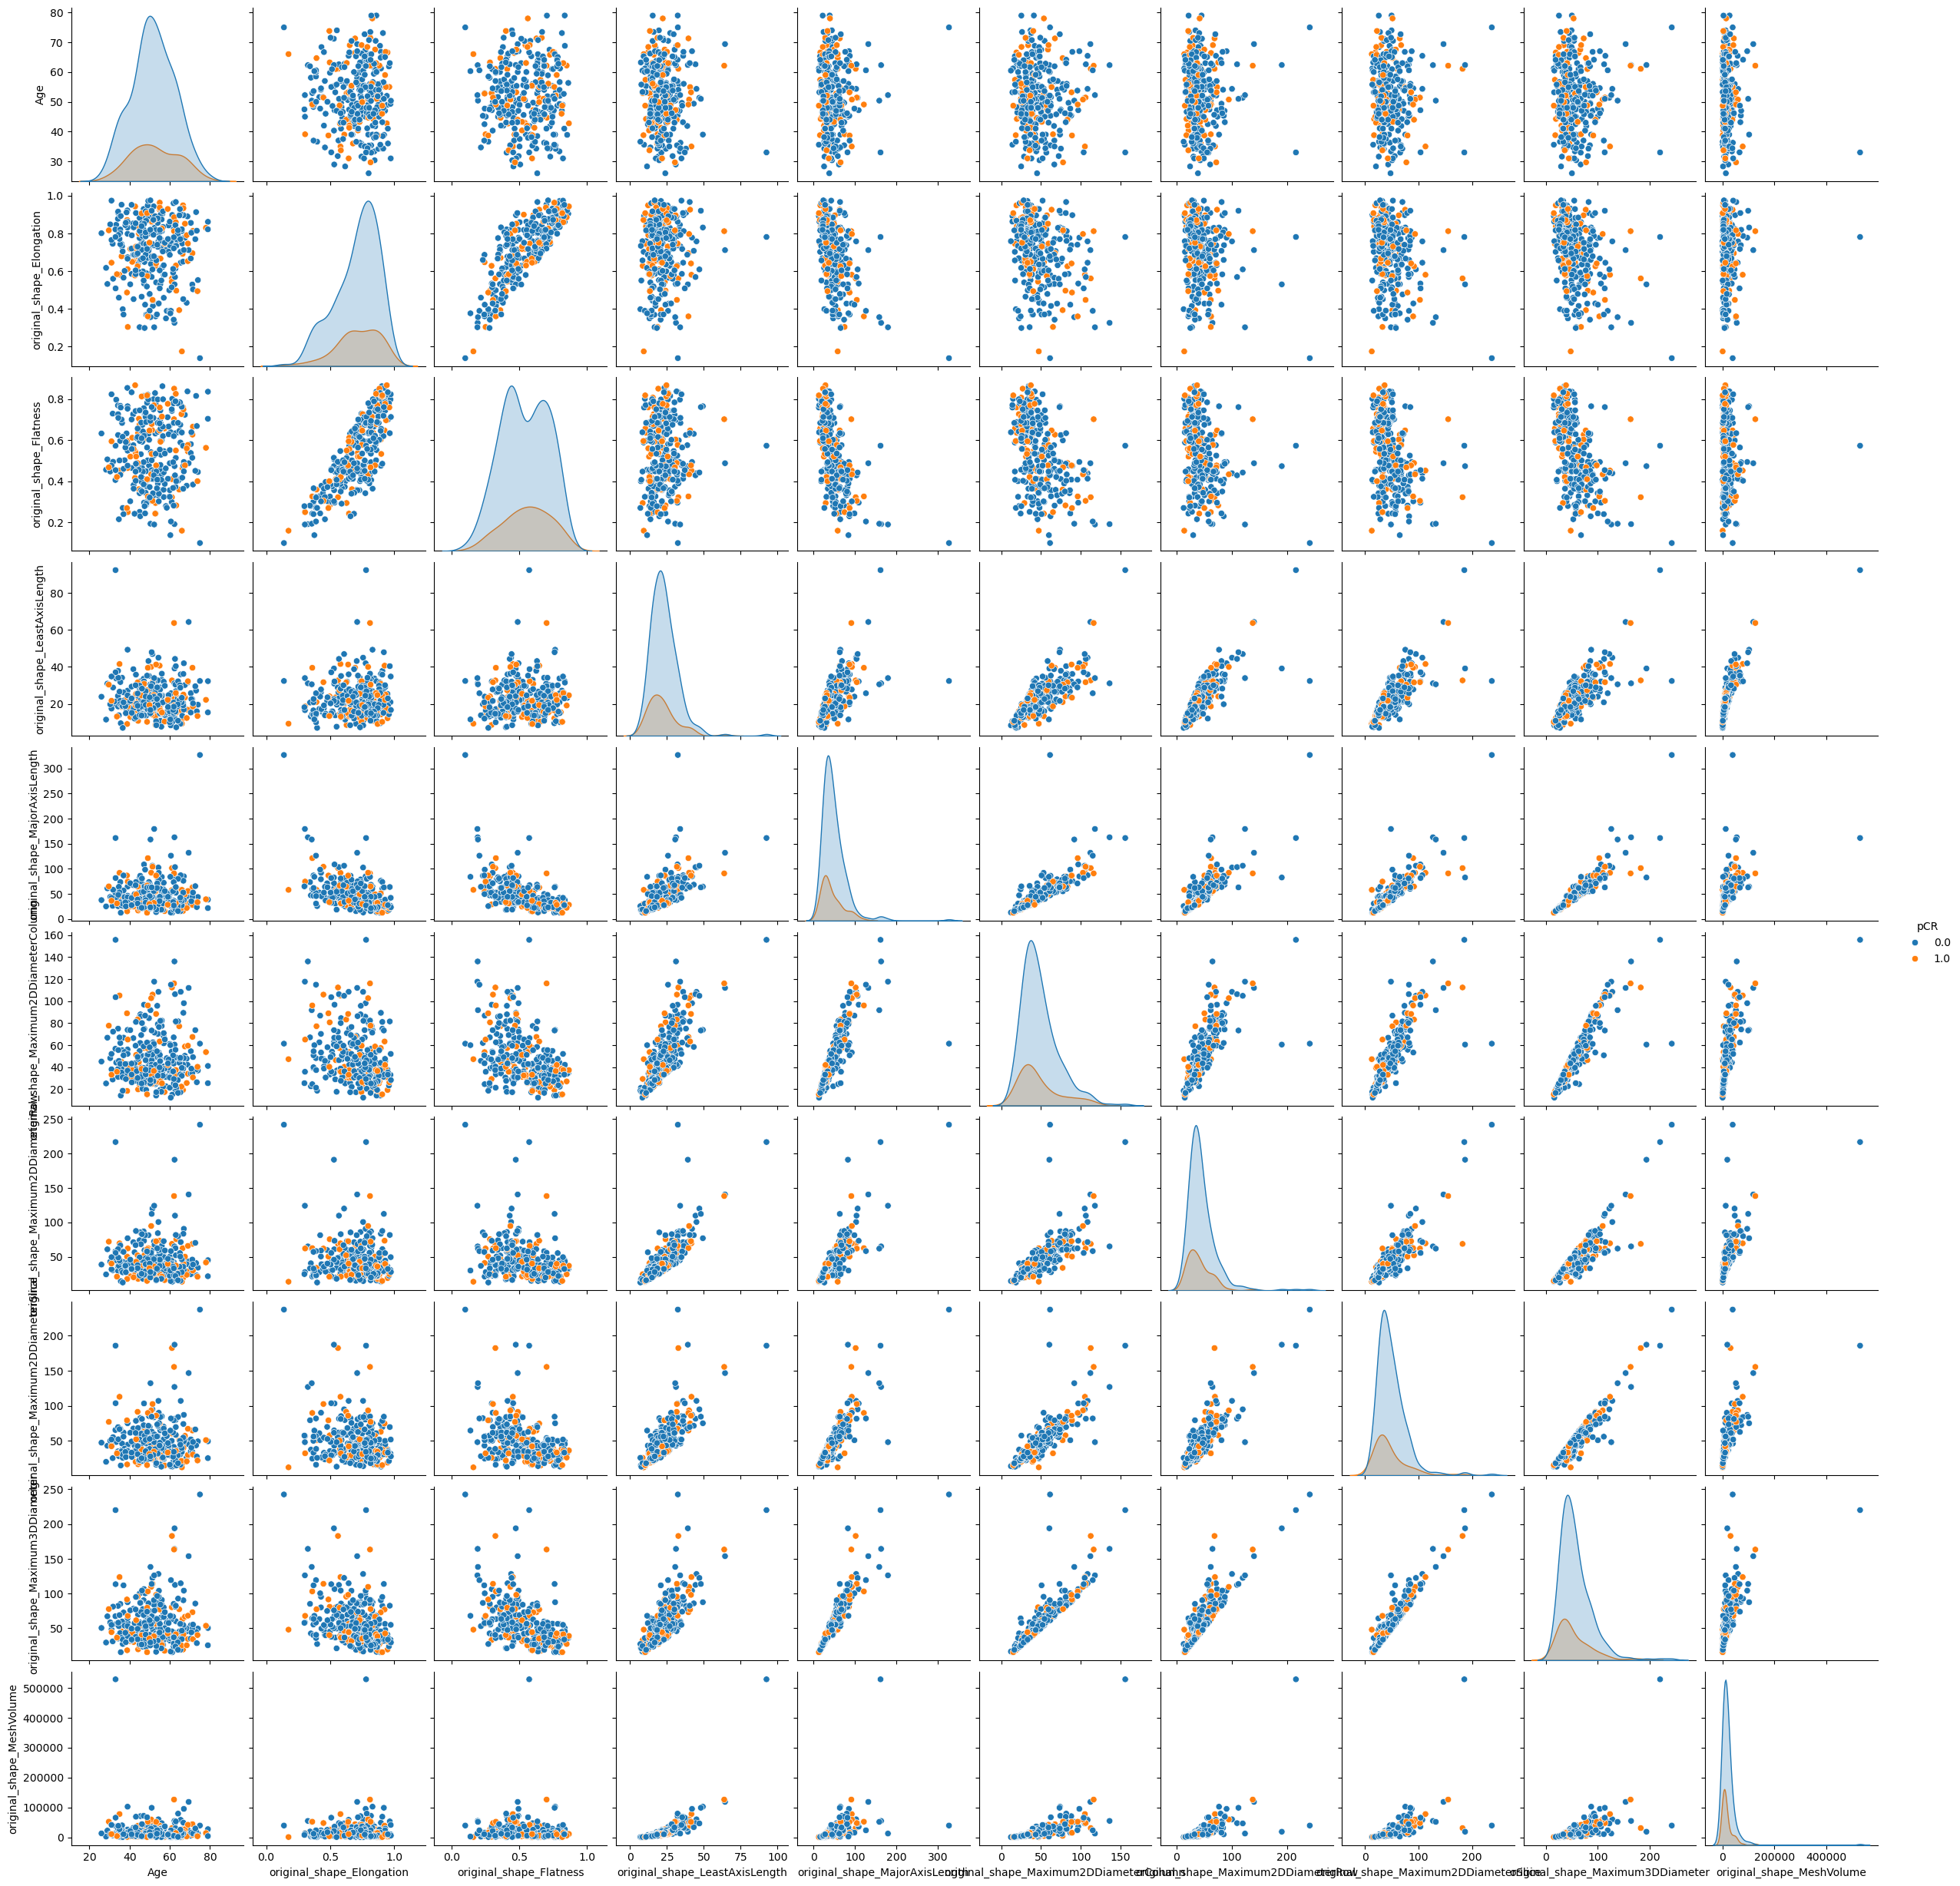

In [275]:
# Pairs plots
# add pcr to color pairs plots to check more clearly
list_cont_pcr = list_cont[:]
list_cont_pcr.pop(list_cont_pcr.index('RelapseFreeSurvival'))
list_cont_pcr.insert(0,'pCR')
df.loc[:,list_cont_pcr]

sns.pairplot(data=df.loc[:,list_cont_pcr[0:11]],hue='pCR')


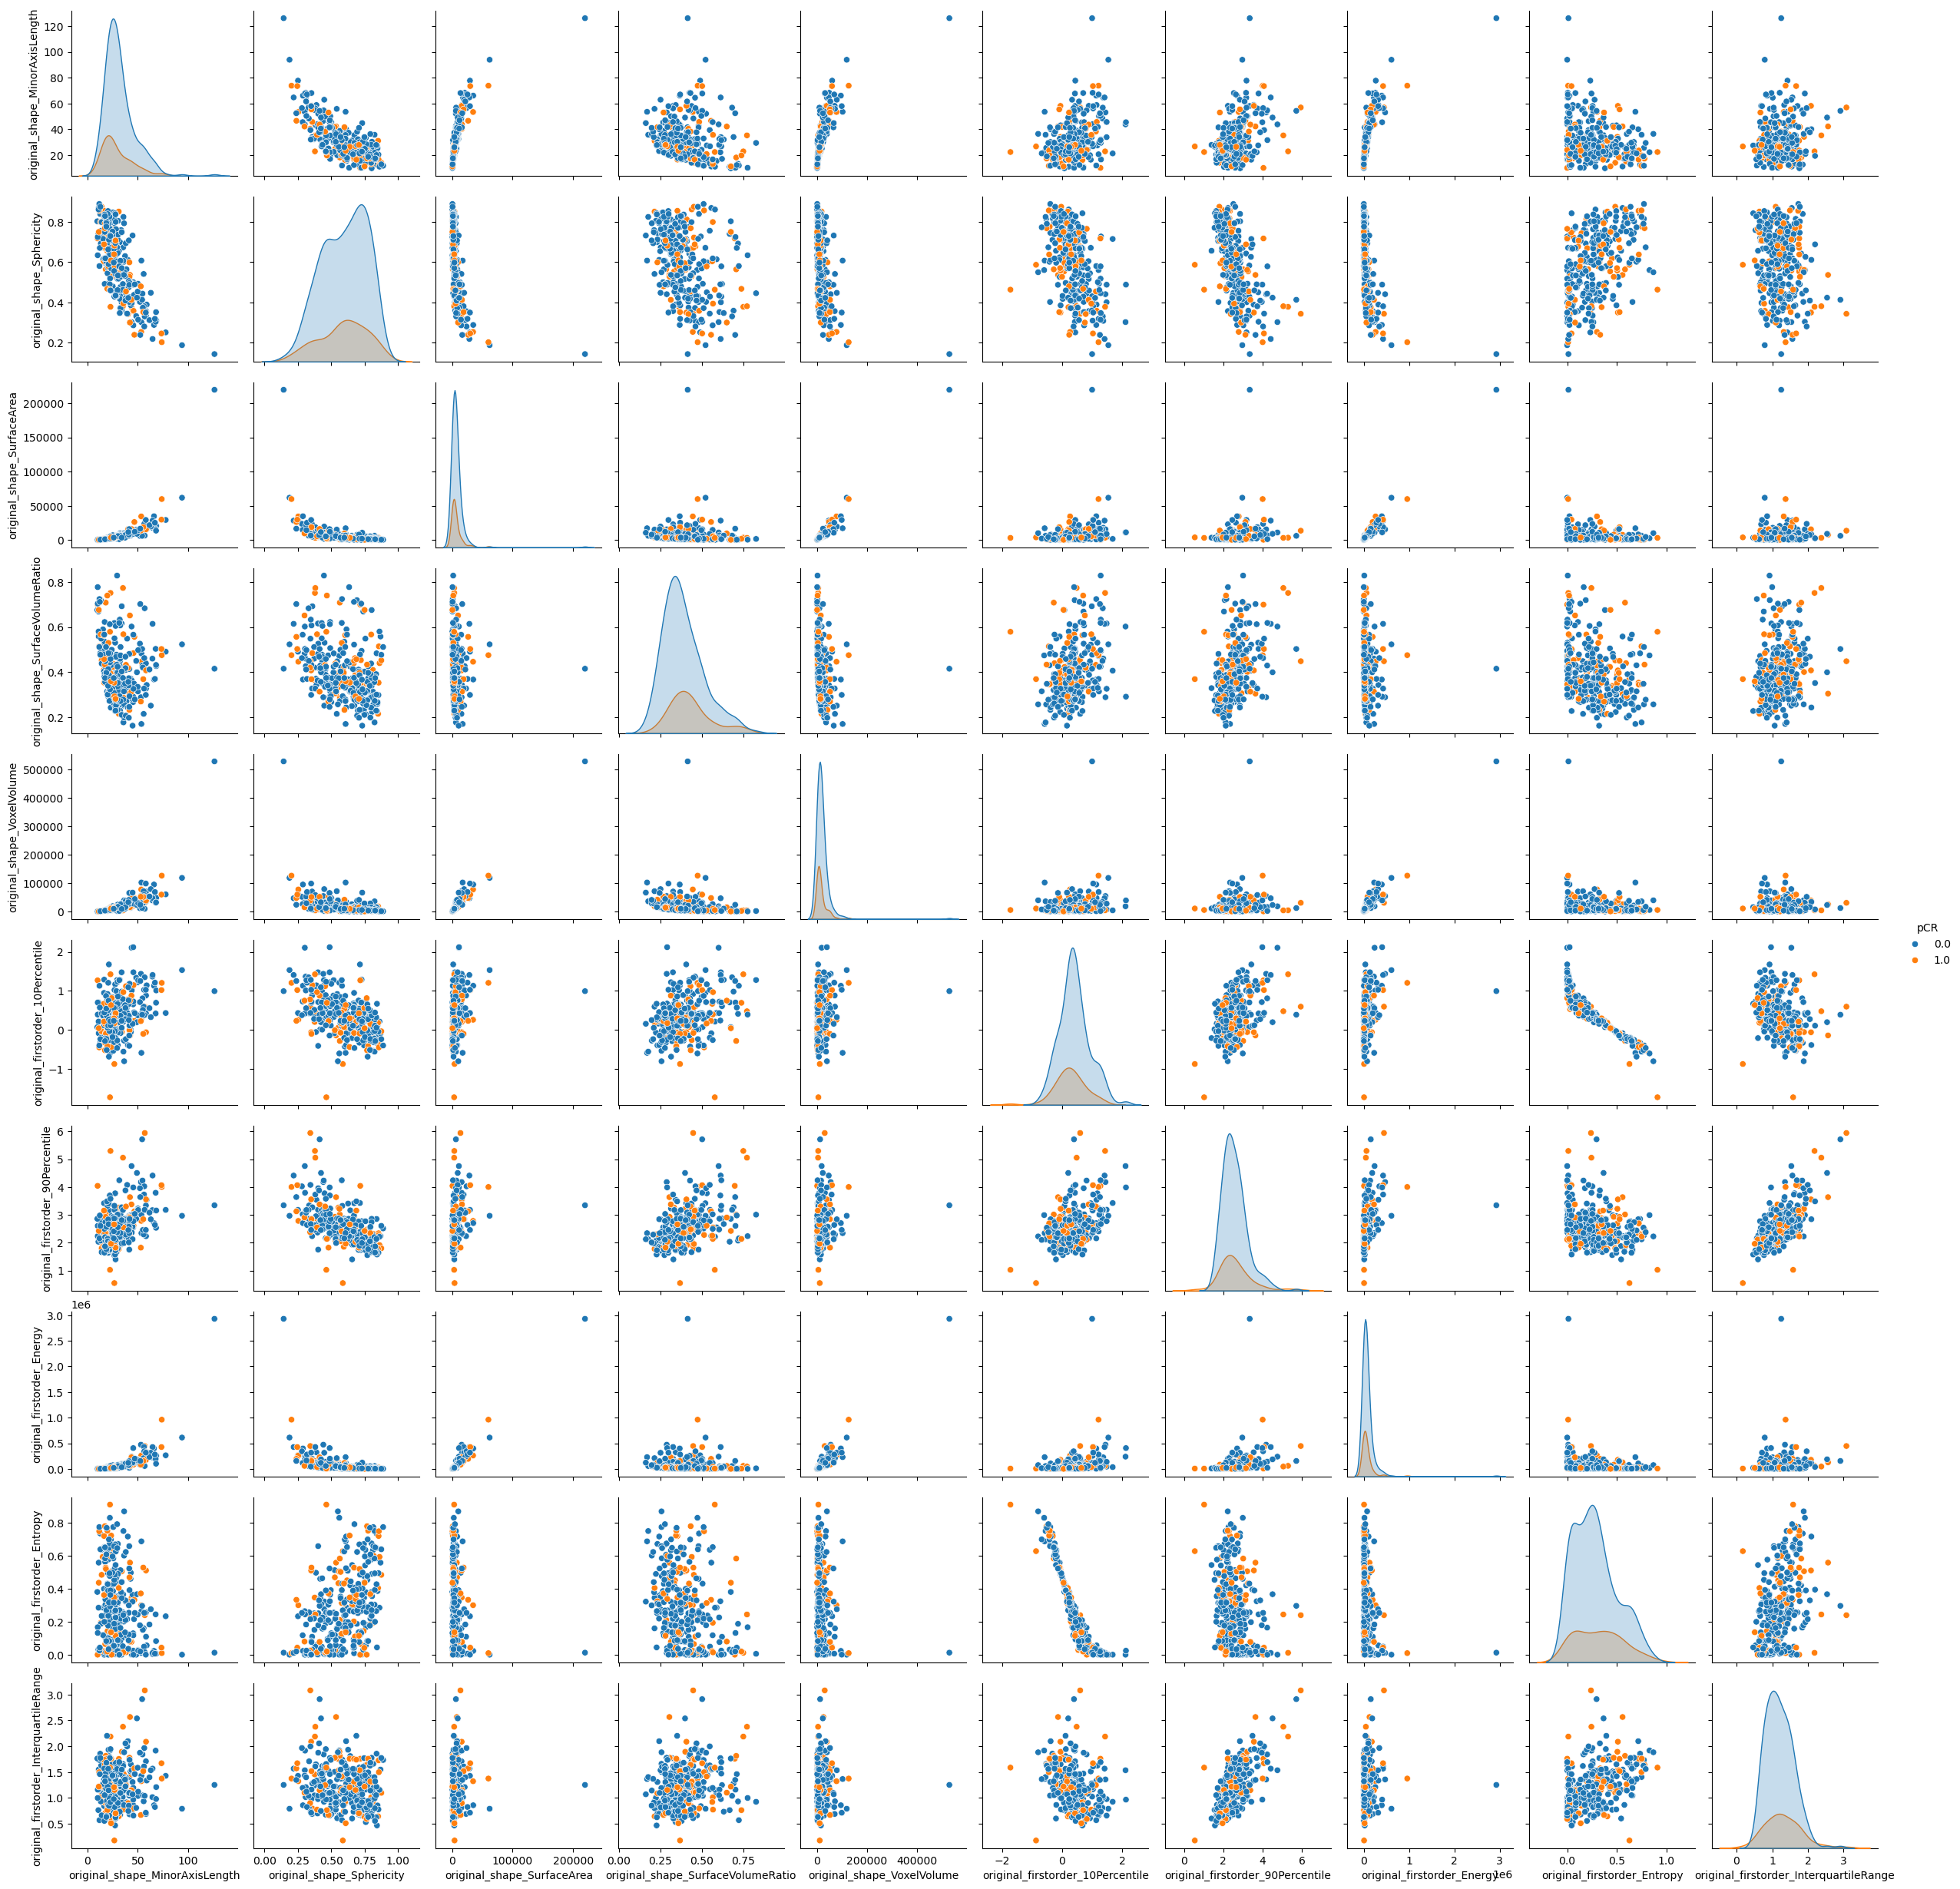

In [276]:
l2 = list_cont_pcr[11:21]
l2.insert(0,'pCR')
sns.pairplot(data=df.loc[:,l2],hue='pCR')

## comparing fearure ranges
 - Huge difference between feature ranges, normalization necessary

<AxesSubplot:>

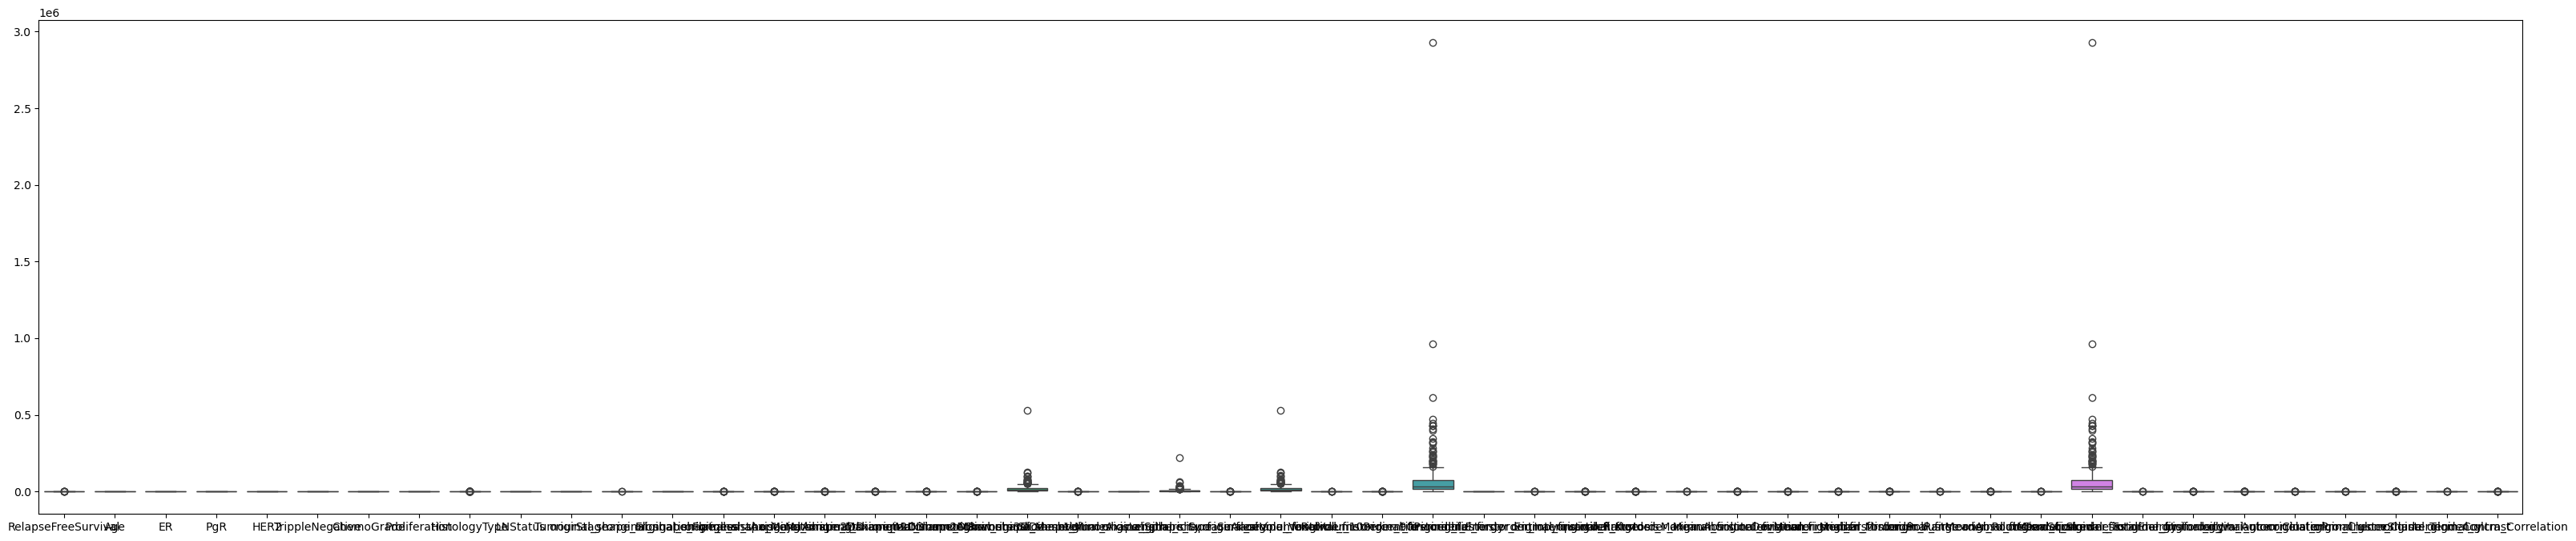

In [277]:

fig,ax=plt.subplots(1,figsize=(40,8))
sns.boxplot(data=df.iloc[:,1:50],ax=ax)

## Lets deal with outliers!!
- Identify them by using factor 1.5*IQR, 
Ref: Brownlee, J., 2020. Data preparation for machine learning: data cleaning, feature selection, and data transforms in Python. Machine Learning Mastery.
- lets replace them with median values!

In [278]:
class OutlierRemover:
    """
    Takes `dataframe` as an input and list of continuous features in data frame 'cont_features_list'
    to get a list of features with outliers pass `.features_with_outliers` attribute to OutlierRemover object instance
    """
    def __init__(self,dataframe,cont_features_list):
        self.dataframe = dataframe
        self.cont_features_list = cont_features_list


    def transform(self,factor=3):
        """
        Factor is a multiplying factor to the interquartile range (IQR), cutoff = factor*IQR. Default is 3 for extreme outliers, 1.5 can be used.
        An outlier is identified as feature value that is larger than 3rd quatile + cutoff or less 1st quartile - cutoff value.
        """
        data_cont = self.dataframe.loc[:,self.dataframe.columns.isin(self.cont_features_list)]
        p25, p50, p75 = np.nanquantile(data_cont,.25,axis=0),np.nanquantile(data_cont,.5,axis=0),np.nanquantile(data_cont,.75,axis=0)

        cutoff = factor*(p75-p25) 
        lower, upper = p25 - cutoff, p75 + cutoff

        dict_upper = dict()
        dict_lower = dict()
        dict_med = dict()
        for low, up, med,col in zip(lower,upper,p50,data_cont.columns.values):
            dict_lower[col] = low
            dict_upper[col] = up
            dict_med[col] = med


        self.features_with_outliers = []
        for col in data_cont.columns.values:
            if any(data_cont[col]<dict_lower[col]) or any(data_cont[col]>dict_upper[col]):
                self.features_with_outliers.append(col)

        # for col in data_cont.columns.values:
        for col in self.features_with_outliers:
            data_cont.loc[data_cont[col]>dict_upper[col],col] = dict_med[col]
            data_cont.loc[data_cont[col]<dict_lower[col],col] = dict_med[col]

        # Combine transformed features back to original data
        df1 = self.dataframe.loc[:,~self.dataframe.columns.isin(list_cont)]
        
        return pd.merge(df1,data_cont,left_index=True,right_index=True)

## Continuous features vs `pCR`
- not much to see through, statistical tests will complement

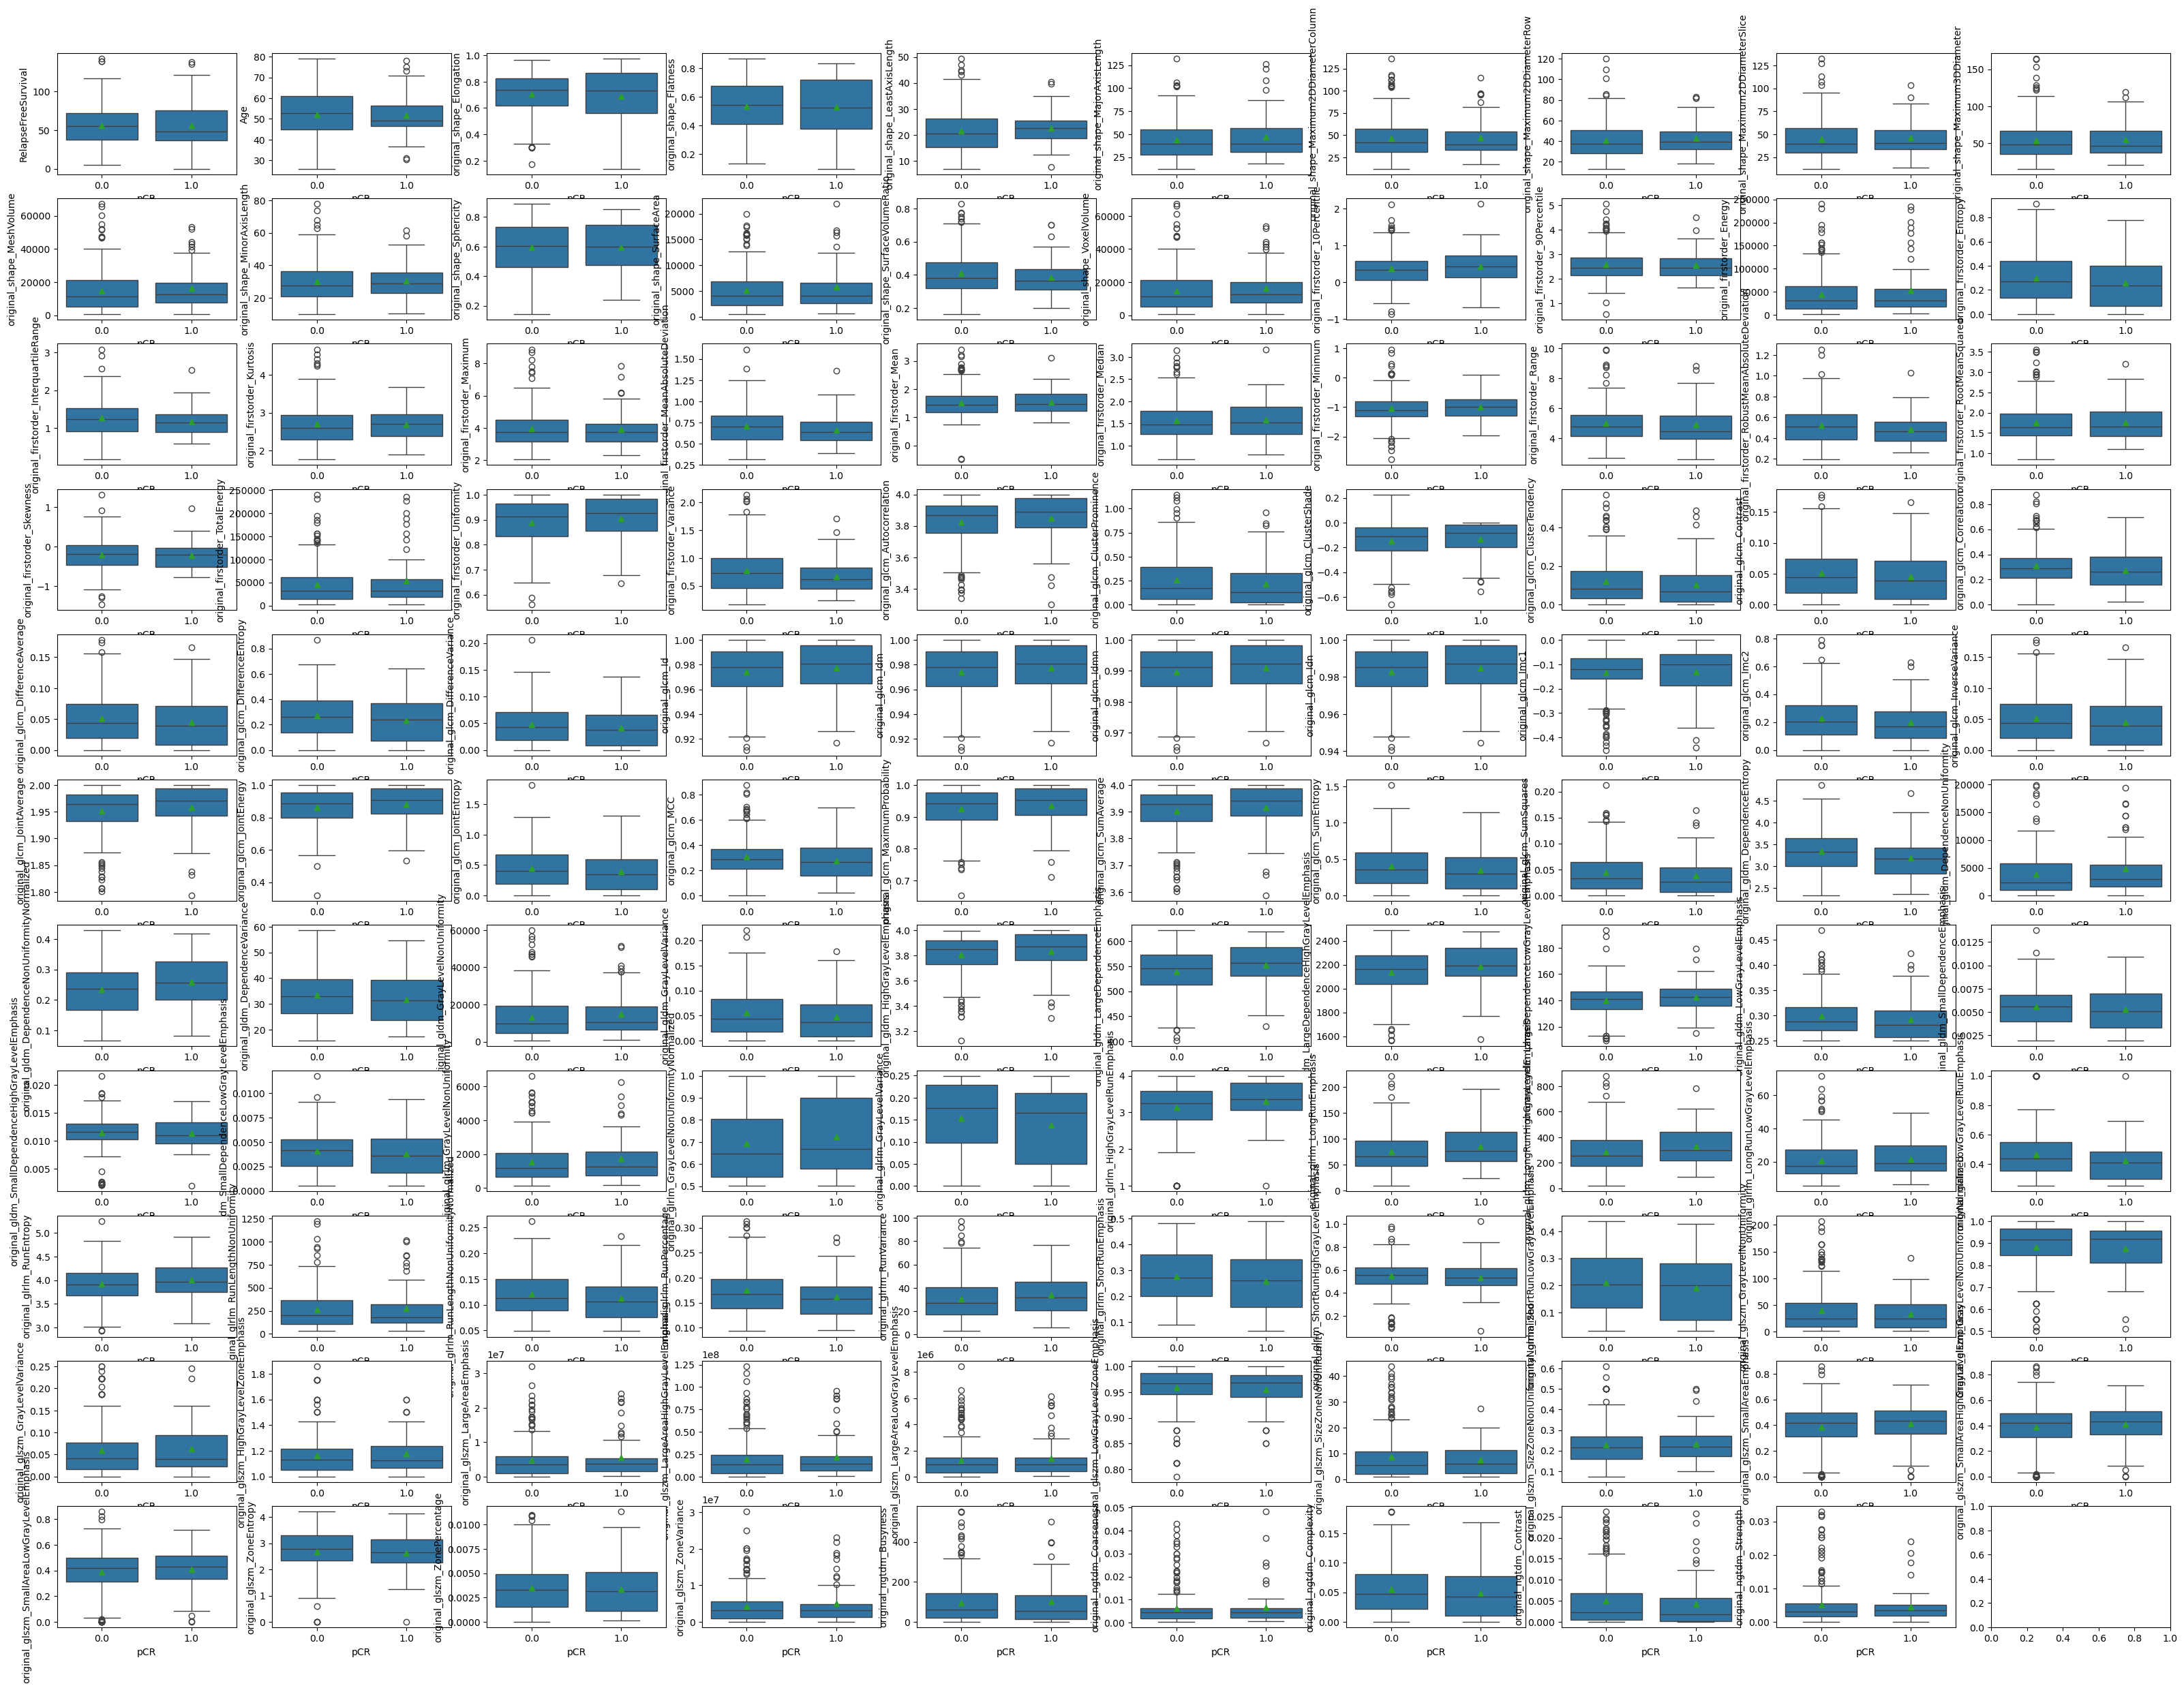

In [279]:
ourm = OutlierRemover(data_cont,list_cont)
data_cont_ourm = ourm.transform()
# Visualize boxplots
fig, axs = plt.subplots(11,10,figsize=(40,30))
ax = axs.ravel()
df_cont_pcr = pd.merge(data_train.loc[:,['pCR']],data_cont_ourm,left_index=True,right_index=True)
for i,j in enumerate(df_cont_pcr.columns.values[1:]):
    sns.boxplot(x = df_cont_pcr['pCR'],y = df_cont_pcr.iloc[:,1:].loc[:,j],ax=ax[i],showmeans=True)

## ANOVA Test
- This will later be incorporated in pipeline for feature selection
- Aova test for two groups, is equivalent to t-test

In [280]:
## ANOVA test
from sklearn.feature_selection import f_classif, SelectKBest
X_anova = data_cont_ourm.iloc[:,1:]
y_anova=data_cat.loc[:,'pCR']

fstats, pvalues = f_classif(X_anova,y_anova)

fselector = SelectKBest(f_classif, k=10)
fselector.fit_transform(X_anova,y_anova)

print(fselector.get_feature_names_out())
print(pvalues[pvalues<0.05])


# print(f"selected features: {X_anova.columns.values[fselector.get_support()]}")
# print(pvalues)



['original_gldm_DependenceEntropy'
 'original_gldm_DependenceNonUniformityNormalized'
 'original_gldm_LargeDependenceEmphasis'
 'original_gldm_LargeDependenceLowGrayLevelEmphasis'
 'original_glrlm_LongRunEmphasis'
 'original_glrlm_LongRunHighGrayLevelEmphasis'
 'original_glrlm_LongRunLowGrayLevelEmphasis' 'original_glrlm_RunEntropy'
 'original_glrlm_RunLengthNonUniformityNormalized'
 'original_glrlm_RunPercentage']
[0.01210902 0.01275602 0.00540101 0.00511461 0.00352895 0.01205129
 0.00313689 0.00490262 0.00503253 0.00135575 0.00243817 0.01083708
 0.00384761 0.01455145]


## Chi-square test for categorical feature selection
 - Only 3 fetures returned a statistically significant test at 5% significance level

In [281]:
from sklearn.feature_selection import chi2
X_chi = df_imp.loc[:,list_cat[1:]]
y_chi = df_imp.loc[:,['pCR']]
chi2_selector = SelectKBest(chi2,k=3)
chi2_selector.fit_transform(X=X_chi,y=y_chi)
pvalues = chi2_selector.pvalues_

print(pvalues[pvalues<0.05])

print(chi2_selector.get_feature_names_out())

[0.03132538 0.01183516 0.00314746]
['ER' 'PgR' 'HER2']


## Logistic classifier
- Bootstrapping improved accuracy

In [282]:
# converts floats to intergers for categorical data
def to_int(df,list_features):
    for f in list_features:
        df[f]=df[f].astype('Int64')
    return df

data_train = to_int(data_train,list_cat)
data_train
data_test = to_int(data_test,list_cat)
data_test

ID  pCR  RelapseFreeSurvival        Age  ER  PgR  HER2  \
246  TRG002709    0            48.000000  53.683778   0    0     0   
349  TRG002870    1            73.750000  66.300000   0    0     1   
47   TRG002384    0            94.000000  62.000000   1    1     0   
219  TRG002671    0            52.000000  48.243669   1    1     0   
215  TRG002664    0            54.000000  46.102669   0    0     0   
..         ...  ...                  ...        ...  ..  ...   ...   
184  TRG002616    0            61.000000  51.723477   0    0     0   
375  TRG002917    0            59.166667  33.500000   0    0     0   
359  TRG002881    0            71.833333  56.400000   1    0     1   
361  TRG002883    0            70.833333  48.100000   0    0     0   
186  TRG002618    1            57.000000  59.425051   0    0     0   

     TrippleNegative  ChemoGrade  Proliferation  ...  \
246                1           2              1  ...   
349                0           2              1  ...   
47                 0           2              1  ...   
219                0           2              1  ...   
215                1           2              1  ...   
..               ...         ...            ...  ...   
184                1           3              3  ...   
375                1           3              3  ...   
359                0           2              1  ...   
361                1           3              3  ...   
186                1           2              1  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  \
246                                       0.394504   
349                                       0.083383   
47                                        0.581353   
219                                       0.494625   
215                                       0.247294   
..                                             ...   
184                                       0.427951   
375                                       0.419745   
359                                       0.750567   
361                                       0.459564   
186                                       0.312501   

     original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
246                                      0.394503                    3.374972   
349                                      0.083377                    1.584963   
47                                       0.581353                    2.662413   
219                                      0.494625                    2.989961   
215                                      0.247294                    3.231270   
..                                            ...                         ...   
184                                      0.427951                    2.405639   
375                                      0.419745                    3.209020   
359                                      0.750567                    1.278358   
361                                      0.459564                    2.992289   
186                                      0.312501                    2.000000   

     original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
246                       0.005753                 1.887473e+06   
349                       0.005566                 3.750289e+04   
47                        0.003759                 8.709857e+06   
219                       0.005453                 2.047252e+06   
215                       0.006067                 4.546581e+05   
..                             ...                          ...   
184                       0.000725                 9.987773e+06   
375                       0.000763                 7.148966e+07   
359                       0.006743                 6.534741e+05   
361                       0.001523                 7.429380e+06   
186                       0.001442                 9.052902e+05   

     original_ngtdm_Busyness  original_ngtdm_Coarseness  \
246         

In [283]:
# Apply robust scaler to image data to scale them and remove outliers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedStratifiedKFold,RepeatedKFold, cross_val_score,cross_val_predict
from sklearn.metrics import balanced_accuracy_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer #For custom transformation functions
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


target = 'pCR'
features_to_exlude_in_x = ['ID','pCR','RelapseFreeSurvival']

def split_x_y(dataframe,features_to_exlude_in_x,target):
    features_to_exlude_in_x.append(target)
    y = dataframe.loc[:,target]
    X = dataframe.loc[:,~dataframe.columns.isin(features_to_exlude_in_x)]
    return X, y

X,y = split_x_y(data_train ,features_to_exlude_in_x,target)

# Test data
X_test, y_test = split_x_y(data_test,features_to_exlude_in_x,target)
Xcols = X_test.columns.values

# categorical features to select from 
list_cat[1:]


imputer = KNNImputer(n_neighbors=1)

cont_pipeline = Pipeline(steps=[('imputer',imputer),
                                ('scaler',RobustScaler()),
                                ('kbest_cont',SelectKBest(f_classif,k=9))])

cat_pipleline = Pipeline(steps=[('imputer',imputer),
                                ('kbest_cat',SelectKBest(chi2,k=4))])

transformer = ColumnTransformer(transformers=[('cont',cont_pipeline,list_cont[1:]),
                                              ('cat',cat_pipleline,list_cat[1:])
                                            ])

regressor = LogisticRegression(max_iter=10_000,class_weight='balanced',random_state=0)
clf_lr = Pipeline(steps=[('processor',transformer),
                         ('regressor',regressor)])

param_grid = {
    'regressor__C':[0.01,0.05,1,2,5,10,20]
    # 'processor__cont__kbest_cont__k':list(range(1,10))
}

cv  = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=0)
grid_search = GridSearchCV(estimator=clf_lr,param_grid=param_grid,cv=cv,n_jobs=-1,scoring='balanced_accuracy')

grid_search.fit(X,y)
clf_lr = grid_search.best_estimator_
ba_cv_clf_lr =cross_val_score(clf_lr,X,y,scoring='balanced_accuracy')

y_pred = clf_lr.predict(X_test)
ba_tst_clf_lr = balanced_accuracy_score(y_true=y_test,y_pred=y_pred)


print(f"BA CV: {np.mean(ba_cv_clf_lr):.3f}, cv_sd: {np.std(ba_cv_clf_lr):.3f}, BA Test: {ba_tst_clf_lr:.3f}")

report=classification_report(y_true=y_test,y_pred=y_pred)
print(report)
clf_lr

BA CV: 0.615, cv_sd: 0.028, BA Test: 0.593
              precision    recall  f1-score   support

         0.0       0.84      0.60      0.70        62
         1.0       0.29      0.59      0.38        17

    accuracy                           0.59        79
   macro avg       0.56      0.59      0.54        79
weighted avg       0.72      0.59      0.63        79



Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('kbest_cont',
                                                                   SelectKBest(k=9))]),
                                                  ['Age',
                                                   'original_shape_Elongation',
                                                   'original_shape_Flatness',
                                                   'original_shape_LeastAxisLength',
                                                   'original_shape_MajorAxisLength',
                                                   'original_shape_Maximum2DDiameterColumn'...
                                                   'original_firstorder_Skewness', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('kbest_cat',
                                                                   SelectKBest(k=4,
                                                                               score_func=<function chi2 at 0x000001B1BCBE8A60>))]),
                                                  ['ER', 'PgR', 'HER2',
                                                   'TrippleNegative',
                                                   'ChemoGrade',
                                                   'Proliferation',
                                                   'HistologyType', 'LNStatus',
                                                   'TumourStage'])])),
                ('regressor',
                 LogisticRegression(C=1, class_weight='balanced',
                                    max_iter=10000, random_state=0))])

In [254]:
## Storing model performance metrics
def model_performance(name,cross_validation_score,test_score):
    metrics = {'name':name,'ba_cv':np.mean(cross_validation_score),'sd':np.std(cross_validation_score),'ba_test':test_score}
    return metrics

perfopmance_clf_lr= model_performance('Logistic',ba_cv_clf_lr,ba_tst_clf_lr)

In [809]:
grid_search.best_params_

{'regressor__C': 1}

In [810]:
# # user function for plotting
# def plot_roc_curve(model):
#     y_proba = model.predict_proba(X_test)
#     fpr, tpr, _ = roc_curve(y_true=y_test,y_score=y_proba[:,1])
#     roc_auc = auc(fpr, tpr)

#     plt.figure()
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic Curve')
#     plt.legend(loc="lower right")
#     plt.show()
# plot_roc_curve(clf_lr)


## Support vaector machines classifieer

In [284]:

from sklearn.utils import resample
from sklearn.svm import SVC
# Define the parameters to tune
parameters_svm = {'svm__C':[0.01,0.05,1,2,5,20],
                  'svm__kernel':['sigmoid']}
# Bootstrapping
ba_cv_scores_svm = []
ba_tst_scores = []
for i in range(150):  # Number of bootstrap samples to create
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Define the model
    svm = SVC(class_weight='balanced')
    clf_svm = Pipeline(steps=[('processor',transformer),
                             ('svm',svm)])
    
    # Define the grid search
    cv  = RepeatedStratifiedKFold(n_splits=10,n_repeats=3)
    grid_search_svm = GridSearchCV(estimator=clf_svm,param_grid=parameters_svm,cv=cv,n_jobs=-1,scoring='balanced_accuracy')
    
    # Fit the grid search
    grid_search_svm.fit(X_sample, y_sample)
    svm = grid_search_svm.best_estimator_
    # Calculate the balanced accuracy with cross-validation
    ba_cv_svm =cross_val_score(svm,X_sample,y_sample,scoring='balanced_accuracy')
    ba_cv_scores_svm.append(np.mean(ba_cv_svm))

# Predict on the test set and calculate the balanced accuracy
y_pred_svm = svm.predict(X_test)
ba_tst_svm = balanced_accuracy_score(y_true=y_test,y_pred=y_pred_svm)


# Calculate the average balanced accuracy over all bootstrap samples
average_ba_cv_svm = np.mean(ba_cv_svm)
# average_ba_tst = np.mean(ba_tst_scores)

print(f"Average BA CV, svm: {average_ba_cv_svm:.3f}, Average BA Test, svm: {ba_tst_svm:.3f}")
svm

Average BA CV, svm: 0.578, Average BA Test, svm: 0.601


Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('kbest_cont',
                                                                   SelectKBest(k=9))]),
                                                  ['Age',
                                                   'original_shape_Elongation',
                                                   'original_shape_Flatness',
                                                   'original_shape_LeastAxisLength',
                                                   'original_shape_MajorAxisLength',
                                                   'original_shape_Maximum2DDiameterColumn'...
                                                   'original_firstorder_Skewness', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('kbest_cat',
                                                                   SelectKBest(k=4,
                                                                               score_func=<function chi2 at 0x000001B1BCBE8A60>))]),
                                                  ['ER', 'PgR', 'HER2',
                                                   'TrippleNegative',
                                                   'ChemoGrade',
                                                   'Proliferation',
                                                   'HistologyType', 'LNStatus',
                                                   'TumourStage'])])),
                ('svm',
                 SVC(C=0.05, class_weight='balanced', kernel='sigmoid'))])

In [814]:
from sklearn.svm import SVC

# Bootstrapping
imputer = KNNImputer(n_neighbors=1)

cont_pipeline = Pipeline(steps=[('imputer',imputer),
                                ('scaler',RobustScaler()),
                                ('kbest_cont',SelectKBest(f_classif))])

cat_pipleline = Pipeline(steps=[('imputer',imputer),
                                ('kbest_cat',SelectKBest(chi2,k=2))])

transformer = ColumnTransformer(transformers=[('cont',cont_pipeline,list_cont[1:]),
                                              ('cat',cat_pipleline,list_cat[1:])
                                            ])


# Define the model
svm = SVC(class_weight='balanced',probability=True, random_state=0)
clf_svm = Pipeline(steps=[('processor',transformer),
                            ('svm',svm)])

# Define the grid search
# Define the parameters to tune
parameters_svm = {'svm__C':[0.01,0.05,1,2,5,20],
                  'processor__cont__kbest_cont__k':list(range(1,11)),
                  'processor__cat__kbest_cat__k':list(range(1,5)),
                  'svm__kernel':['sigmoid']}
cv  = RepeatedStratifiedKFold(n_splits=10,n_repeats=3)
grid_search_svm = GridSearchCV(estimator=clf_svm,param_grid=parameters_svm,cv=cv,n_jobs=-1,scoring='balanced_accuracy')

# Fit the grid search
grid_search_svm.fit(X, y)
svm = grid_search_svm.best_estimator_
# Calculate the balanced accuracy with cross-validation
ba_cv_svm =cross_val_score(svm,X,y,scoring='balanced_accuracy')


# Predict on the test set and calculate the balanced accuracy
y_pred = svm.predict(X_test)
ba_tst_svm = balanced_accuracy_score(y_true=y_test,y_pred=y_pred)


# Calculate the average balanced accuracy over all bootstrap samples
average_ba_cv_svm = np.mean(ba_cv_svm)
# average_ba_tst = np.mean(ba_tst_scores)

print(f"Average BA CV, svm: {np.mean(ba_cv_svm):.3f}, {np.std(ba_cv_svm):.3f} BA Test, svm: {ba_tst_svm:.3f}")

report=classification_report(y_true=y_test,y_pred=y_pred)
print(report)
svm

Average BA CV, svm: 0.577, 0.027 BA Test, svm: 0.622
              precision    recall  f1-score   support

         0.0       0.86      0.60      0.70        62
         1.0       0.31      0.65      0.42        17

    accuracy                           0.61        79
   macro avg       0.58      0.62      0.56        79
weighted avg       0.74      0.61      0.64        79



Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('kbest_cont',
                                                                   SelectKBest(k=1))]),
                                                  ['Age',
                                                   'original_shape_Elongation',
                                                   'original_shape_Flatness',
                                                   'original_shape_LeastAxisLength',
                                                   'original_shape_MajorAxisLength',
                                                   'original_shape_Maximum2DDiameterColumn'...
                                                   'original_firstorder_Skewness', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('kbest_cat',
                                                                   SelectKBest(k=3,
                                                                               score_func=<function chi2 at 0x0000029A0C2E4A60>))]),
                                                  ['ER', 'PgR', 'HER2',
                                                   'TrippleNegative',
                                                   'ChemoGrade',
                                                   'Proliferation',
                                                   'HistologyType', 'LNStatus',
                                                   'TumourStage'])])),
                ('svm',
                 SVC(C=0.05, class_weight='balanced', kernel='sigmoid',
                     probability=True, random_state=0))])

In [285]:
perfopmance_reg_svm_smote = model_performance('SVM SMOTE',ba_cv_svm,ba_tst_svm)


## Random forest Classifier
- Does not require feature selection, since by its design has inbuit feature selection methods
- Thus model is trained with all features included, redundant features will be dropped automatically


In [306]:
# Apply robust scaler to image data to scale them and remove outliers
# With feature selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedStratifiedKFold,RepeatedKFold, cross_val_score,cross_val_predict
from sklearn.metrics import balanced_accuracy_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import TransformedTargetRegressor
from imblearn.ensemble import BalancedRandomForestClassifier

imputer = KNNImputer(n_neighbors=1)

clf_rf = BalancedRandomForestClassifier(200,random_state=0,bootstrap=True,class_weight='balanced_subsample')

model_rf = Pipeline(steps=[('imputer',imputer),('classifier',clf_rf)])


param_grid = param_grid = {#'classifier__max_features': [2,4,6,8,13],
                           'classifier__max_depth': [2,3,4,6]}

cv = RepeatedStratifiedKFold(n_repeats=4,n_splits=10,random_state=0)
grid_search = GridSearchCV(estimator=model_rf,param_grid=param_grid,cv=cv,scoring='balanced_accuracy',n_jobs=-1)
grid_search.fit(X=X,y=y)
bal_random_forest = grid_search.best_estimator_
best_parameters = grid_search.best_params_

ba_cv_rf = cross_val_score(bal_random_forest,X,y,scoring='balanced_accuracy')


# Predict and test
y_pred = bal_random_forest.predict(X_test)
ba_test_rf = balanced_accuracy_score(y_true=y_test,y_pred=y_pred)


print(f"BA CV: {np.mean(ba_cv_rf):.3f}, cv_sd: {np.std(ba_cv_rf):.3f}, BA Test: {ba_test_rf:.3f}")
report=classification_report(y_true=y_test,y_pred=y_pred)
print(report)
bal_random_forest

BA CV: 0.609, cv_sd: 0.070, BA Test: 0.587
              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73        62
         1.0       0.29      0.53      0.38        17

    accuracy                           0.62        79
   macro avg       0.56      0.59      0.55        79
weighted avg       0.72      0.62      0.65        79



Pipeline(steps=[('imputer', KNNImputer(n_neighbors=1)),
                ('classifier',
                 BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                max_depth=3, n_estimators=200,
                                                random_state=0))])

In [307]:
perfopmance_bal_rf = model_performance('Random Forest',ba_cv_rf,ba_test_rf)


## XGBoost Classifier

In [291]:
# simple xgboost
# Apply robust scaler to image data to scale them and remove outliers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedStratifiedKFold,RepeatedKFold, cross_val_score,cross_val_predict
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import TransformedTargetRegressor

# Dataframe used is df_imputed, processing steps are embedded in a pipeline
target = 'pCR'
features_to_exlude_in_x = ['ID','pCR','RelapseFreeSurvival']


X,y = split_x_y(data_train,features_to_exlude_in_x,target)


X_test, y_test = split_x_y(data_test,features_to_exlude_in_x,target)
Xcols = X_test.columns.values

imputer = Pipeline(steps=[('knn_imputer',KNNImputer(n_neighbors=1))])
cv = RepeatedStratifiedKFold(n_repeats=3,n_splits=10,random_state=0)
classifier = XGBClassifier(scale_pos_weight = 0.78/0.22,n_jobs=-1) 
model = Pipeline(steps=[('imputer',imputer),('classifier',classifier)])


# Learning rate controls overfitting, the smaller learning rate means less correction is made to the preceding tree
# low value for learning rate  results into more trees
# `colsample_bytree` fraction of features to be used to build tree
# `gamma` minimum loss reduction to make split. It is pseudo-regularization hyperparameter for complexity control

param_grid = param_grid = {#'classifier__n_estimators': [100,200,300],
                            'classifier__max_depth': [3,4,5],
                            'classifier__learning_rate': [0.1,0.05,0.01],
                            'classifier__gamma': [0,0.25,1],
                            'classifier__colsample_bytree':[0.05,0.1,0.15]}

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=cv,scoring='balanced_accuracy')
grid_search.fit(X,y)
xgb = grid_search.best_estimator_
ba_xgb_cv = cross_val_score(xgb, X, y, cv=cv, scoring='balanced_accuracy')



y_pred = xgb.predict(X_test)
ba_xgb_test = balanced_accuracy_score(y_true=y_test,y_pred=y_pred)

print(f"Cross-validation accuracy: {ba_xgb_cv.mean():.2f}, SD: {ba_xgb_cv.std():.2f}")
print(f"Test accuracy: {ba_xgb_test:.2f}")
report=classification_report(y_true=y_test,y_pred=y_pred)
print(report)
xgb

Cross-validation accuracy: 0.61, SD: 0.09
Test accuracy: 0.59
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85        62
         1.0       0.42      0.29      0.34        17

    accuracy                           0.76        79
   macro avg       0.62      0.59      0.60        79
weighted avg       0.73      0.76      0.74        79



Pipeline(steps=[('imputer',
                 Pipeline(steps=[('knn_imputer', KNNImputer(n_neighbors=1))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.15,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [301]:
perfopmance_xgb = model_performance('XGBoost',ba_xgb_cv,ba_xgb_test)

In [829]:
# plot_roc_curve(xgb)

In [310]:
from sklearn.ensemble import VotingClassifier

clf_voting = VotingClassifier(estimators=[('random_forest',bal_random_forest),('logit',clf_lr), ('xgb',xgb)],voting='soft')
cv = RepeatedStratifiedKFold(random_state=0,n_repeats=3,n_splits=5)
ba_cv_voting = cross_val_score(clf_voting, X, y, cv=cv, scoring='balanced_accuracy')
clf_voting.fit(X=X,y=y)


y_pred = clf_voting.predict(X_test)
ba_test_voting = balanced_accuracy_score(y_true=y_test,y_pred=y_pred)
report=classification_report(y_true=y_test,y_pred=y_pred,output_dict=True)
print(f"CV BA {np.mean(ba_cv_voting):.3f} SD {np.std(ba_cv_voting):.3f} Test BA: {ba_test_voting:.3f}")
print(report)

CV BA 0.653 SD 0.067 Test BA: 0.614
{'0.0': {'precision': 0.8392857142857143, 'recall': 0.7580645161290323, 'f1-score': 0.7966101694915255, 'support': 62.0}, '1.0': {'precision': 0.34782608695652173, 'recall': 0.47058823529411764, 'f1-score': 0.39999999999999997, 'support': 17.0}, 'accuracy': 0.6962025316455697, 'macro avg': {'precision': 0.593555900621118, 'recall': 0.6143263757115749, 'f1-score': 0.5983050847457627, 'support': 79.0}, 'weighted avg': {'precision': 0.7335285792908247, 'recall': 0.6962025316455697, 'f1-score': 0.711263677322463, 'support': 79.0}}


## SAVE BEST MODEL FOR TESTING

In [320]:

import pickle

with open('clf_voting.pkl', 'wb') as f:
    pickle.dump(clf_voting, f)

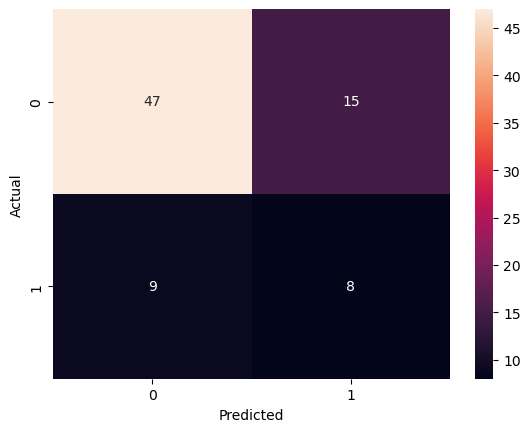

In [311]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [312]:
perfopmance_voting = model_performance('Voting Ensemble',ba_cv_voting,ba_test_voting)

In [313]:
## comparison of model performance
model_name = []
cv_score = []
sd_cv_score = []
test_score = []
metrics_list = [perfopmance_clf_lr,perfopmance_bal_rf,perfopmance_xgb,perfopmance_voting]

for m in metrics_list:
    model_name.append(m['name'])
    cv_score.append(m['ba_cv'])
    sd_cv_score.append(m['sd'])
    test_score.append(m['ba_test'])


comparison = pd.DataFrame({'Model':model_name,'Cross Validation':cv_score, 'SD':sd_cv_score, 'Test':test_score})
print('Balanced Accuracy')
comparison

Balanced Accuracy


Model  Cross Validation        SD      Test
0         Logistic          0.615454  0.027986  0.592505
1    Random Forest          0.609331  0.070034  0.587287
2          XGBoost          0.609504  0.085895  0.590607
3  Voting Ensemble          0.653415  0.066573  0.614326

## EXPORT LATEX TABLE FOR REPORT

In [318]:
import os
# Model comparison
try:
    # Create the directory if it doesn't exist
    dest_path = './Report_ML'
    os.makedirs(dest_path, exist_ok=True)

    # Convert DataFrame to LaTeX
    reg_mae = comparison.to_latex(float_format='%.3f',index=False)
    print(reg_mae)
    # Write the LaTeX string to the file
    with open('./Report_ML/clf_ba.tex', 'w') as f:
        f.write(reg_mae)
except Exception as e:
    print(e)


# Classification report
try:
    df = pd.DataFrame(report).transpose()
    indices = df.index.values
    indices2 = []
    for s in df.index.values:
        indices2.append(re.sub(r'\.0','',s))

    df.index = indices2
    
    # Export to LaTeX
    clf_report = df.to_latex(float_format='%.2f')

    print(clf_report)
    with open('./Report_ML/clf_report.tex', 'w') as f:
            f.write(clf_report)
except Exception as e:
    print(e)


\begin{tabular}{lrrr}
\toprule
Model & Cross Validation & SD & Test \\
\midrule
Logistic & 0.615 & 0.028 & 0.593 \\
Random Forest & 0.609 & 0.070 & 0.587 \\
XGBoost & 0.610 & 0.086 & 0.591 \\
Voting Ensemble & 0.653 & 0.067 & 0.614 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.84 & 0.76 & 0.80 & 62.00 \\
1 & 0.35 & 0.47 & 0.40 & 17.00 \\
accuracy & 0.70 & 0.70 & 0.70 & 0.70 \\
macro avg & 0.59 & 0.61 & 0.60 & 79.00 \\
weighted avg & 0.73 & 0.70 & 0.71 & 79.00 \\
\bottomrule
\end{tabular}



In [315]:
# df = pd.DataFrame(report).transpose()
indices = df.index.values
indices2 = []
for s in df.index.values:
    indices2.append(re.sub(r'\.0','',s))

indices2

['0', '1', 'accuracy', 'macro avg', 'weighted avg']